# jupiter –Ω–æ—É—Ç–±—É–∫ —Å —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞–º–∏ - —á–µ—Ä–Ω–æ–≤–∏–∫


In [33]:
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import demoji
import difflib
from razdel import sentenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import pickle



[nltk_data] Downloading package punkt to /Users/ilmira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilmira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ilmira/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
def get_unnecessary_text(row):
    """
    –ë–µ—Ä–µ—Ç —Å—Ç—Ä–æ–∫—É –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞, —Å—Ä–∞–≤–Ω–∏–≤–∞–µ—Ç –î–û/–£/–¢–°/–ü—Ä 
    –∏ –≤–æ–∑–≤—Ä–∞—â–µ—Ç –Ω–µ–∏—Å–ø–æ–ª—å–∑—É–µ–º—ã–π —Ç–µ–∫—Å—Ç
    """
    if len(row['responsibilities']) < 1:
        return ""
    
    # –ø–æ–∫–∞ –∑–∞–¥–∞–µ–º —Ç–∞–∫
    unnecessary_text = row['responsibilities']

    # –≤—ã—Ç–∞—Å–∫–∏–≤–∞–µ–º –∏–∑ unnecessary_text - —Ç–µ–∫—Å—Ç (requirements)
    if len(row['requirements']) > 8:
        diff = difflib.ndiff(unnecessary_text.split(), row['requirements'].split())
        unnecessary_text = ' '.join([word[2:] for word in diff if word.startswith('- ')])

    # –≤—ã—Ç–∞—Å–∫–∏–≤–∞–µ–º –∏–∑ unnecessary_text - —Ç–µ–∫—Å—Ç (terms)
    if len(row['terms']) > 8:
        diff = difflib.ndiff(unnecessary_text.split(), row['terms'].split())
        unnecessary_text = ' '.join([word[2:] for word in diff if word.startswith('- ')])

    # –≤—ã—Ç–∞—Å–∫–∏–≤–∞–µ–º –∏–∑ unnecessary_text - —Ç–µ–∫—Å—Ç (notes)
    if len(row['notes']) > 8:
        diff = difflib.ndiff(unnecessary_text.split(), row['notes'].split())
        unnecessary_text = ' '.join([word[2:] for word in diff if word.startswith('- ')])

    return unnecessary_text


def del_emoji(text):
    text = demoji.replace(str(text), "")
    text = text.replace("‚úî", "").replace("‚ñâ", "")
    return text


def split_sentences(text):
    return [sentence.text for sentence in sentenize(text)]


def get_df_with_labels(input_series, label):
    combined_list = sum(input_series.tolist(), [])
    res_df = pd.DataFrame(
        {'text': combined_list, 'label': label}
    )
    res_df = res_df[
        (res_df['text'] != "") &
        (res_df['text'] != " ") &
        (res_df['text'] != "-") &
        (res_df['text'] != "\\N")
    ]
    
    return res_df


def get_df_for_training():

    df_1 = get_df_with_labels(
        df['unnecessary_text_split'],
        label='null_class'
    )

    df_2 = get_df_with_labels(
        df['requirements_split'],
        label='requirements'
    )

    df_3 = get_df_with_labels(
        df['terms_split'],
        label='terms'
    )

    df_4 = get_df_with_labels(
        df['notes_split'],
        label='notes'
    )

    res_df = pd.concat([df_1, df_2, df_3, df_4]).reset_index(drop=True)
    return res_df


def preprocess_text(text):

    # –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É
    text = text.lower()
    
    # —á–∏—Å—Ç–∏–º —Å –ø–æ–º–æ—â—å—é —Ä–µ–≥—É–ª—è—Ä–æ–∫
    text = del_n.sub(' ', text)
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)

    # —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è
    tokens = word_tokenize(text)

    # —É–¥–∞–ª–µ–Ω–∏–µ —Å—Ç–æ–ø-—Å–ª–æ–≤
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]

    # –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—è
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # –æ–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ —Ç–æ–∫–µ–Ω–æ–≤ –æ–±—Ä–∞—Ç–Ω–æ –≤ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()



In [35]:

# –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –∏–∑ —Ñ–∞–π–ª–∞ Excel
df = pd.read_excel('../data/data_train.xlsx', sheet_name='–ú–ê–ö–°–£')


# –æ—Ç–±–æ—Ä –∫–æ–ª–æ–Ω–æ–∫
cols = [
    # 'id',
    'responsibilities(–î–æ–ª–∂–Ω–æ—Å—Ç–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏)',
    'requirements(–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é)',
    'terms(–£—Å–ª–æ–≤–∏—è)',
    'notes(–ü—Ä–∏–º–µ—á–∞–Ω–∏—è)'
]
df = df[cols].set_index(pd.Index(range(2, len(df) + 2)))

# –ø–µ—Ä–µ–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ –¥–ª—è —É–¥–æ—Å—Ç–≤–∞
df = df.rename(
    columns={
        'responsibilities(–î–æ–ª–∂–Ω–æ—Å—Ç–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏)': 'responsibilities',
        'requirements(–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é)': 'requirements',
        'terms(–£—Å–ª–æ–≤–∏—è)': 'terms',
        'notes(–ü—Ä–∏–º–µ—á–∞–Ω–∏—è)': 'notes'
    }
)

# –∑–∞–ø–æ–ª–Ω–µ–Ω–∏–µ NaN
df['responsibilities'] = df['responsibilities'].fillna('')
df['requirements'] = df['requirements'].fillna('')
df['terms'] = df['terms'].fillna('')
df['notes'] = df['notes'].fillna('')

# —É–¥–∞–ª–µ–Ω–∏–µ —Å–º–∞–π–ª–æ–≤ –∏ –ø–æ—Å—Ç–æ—Ä–æ–Ω–Ω–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ - –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥ –ø–æ –≤—Å–µ–º –Ω—É–∂–Ω—ã–º –∫–æ–ª–æ–Ω–∫–∞–º
# df = df.applymap(preprocess_text)

df = df.applymap(del_emoji)



/Users/ilmira/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [36]:
df.columns

Index(['responsibilities', 'requirements', 'terms', 'notes'], dtype='object')

In [37]:
stop_words = set(stopwords.words('russian'))  # –ó–∞–º–µ–Ω–∏—Ç–µ 'english' –Ω–∞ —è–∑—ã–∫ –≤–∞—à–µ–≥–æ —Ç–µ–∫—Å—Ç–∞
lemmatizer = WordNetLemmatizer()


# --- –î–ª—è –æ–±—É—á–µ–Ω–∏—è ---

In [38]:
# –≤—ã—Ç–∞—â–∏–º —Ç–µ–∫—Å—Ç –¥–ª—è –æ–±—É—á–µ–Ω–∏—è

# —Ç–µ–∫—Å—Ç, –∫–æ—Ç–æ—Ä—ã–π –Ω–µ –∏—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –≤ –∫–æ–ª–æ–Ω–∫–∞—Ö (null_class)
df['unnecessary_text'] = df.apply(
    get_unnecessary_text,
    axis=1
)


In [39]:
# # –≤—ã–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
df['unnecessary_text_split'] = df['unnecessary_text'].apply(split_sentences)
# df['responsibilities_split'] = df['responsibilities'].apply(split_sentences)
df['requirements_split'] = df['requirements'].apply(split_sentences)
df['terms_split'] = df['terms'].apply(split_sentences)
df['notes_split'] = df['notes'].apply(split_sentences)

# # # –≤—ã–¥–µ–ª–µ–Ω–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
# df['unnecessary_text_split'] = df['unnecessary_text'].apply(sent_tokenize)
# # df['responsibilities_split'] = df['responsibilities'].apply(split_sentences)
# df['requirements_split'] = df['requirements'].apply(sent_tokenize)
# df['terms_split'] = df['terms'].apply(sent_tokenize)
# df['notes_split'] = df['notes'].apply(sent_tokenize)


In [40]:
df_for_training = get_df_for_training()
df_for_training

text       label
0     –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...  null_class
1                 –°–±–æ—Ä–∫–∞ –∏ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –∏ –ø–ª–æ—Å–∫–∏—Ö...  null_class
2                                       –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.  null_class
3                                              —Å—Ç–∞–Ω–∫–∞—Ö.  null_class
4     –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ —Å–±–æ—Ä–∫–µ –∏ –≤—è–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω—ã—Ö ...  null_class
...                                                 ...         ...
9430  –ü–ª—é—Å–æ–º 7000 —Ä—É–±–ª–µ–π –≤ –º–µ—Å—è—Ü –∫–∞–∂–¥–æ–º—É –º–æ–Ω—Ç–∞–∂–Ω–∏–∫—É ...       notes
9431       –†–∞–±–æ—Ç–∞ –Ω–µ —Å–ª–æ–∂–Ω–∞—è, –±–µ—Ä—ë–º –±–µ–∑ –æ–ø—ã—Ç–∞ (–æ–±—É—á–∞–µ–º)       notes
9432  –ù–∞—à–∞ –∫–æ–º–ø–∞–Ω–∏—è —è–≤–ª—è–µ—Ç—Å—è –ø—Ä—è–º—ã–º —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª–µ–º —Å ...       notes
9433  –ë–æ–ª–µ–µ 17 –ª–µ—Ç —Ä–∞–±–æ—Ç–∞–µ–º –Ω–∞ —Ä—ã–Ω–∫–µ —Ç—Ä—É–¥–∞ –∏ –ø—Ä–µ–¥–æ—Å—Ç...       notes
9434  –°–µ–π—á–∞—Å –Ω–∞ –æ–±—ä–µ–∫—Ç–∞—Ö —Ç—Ä—É–¥–∏—Ç—Å—è 1893+ —á–µ–ª–æ–≤–µ–∫–∞ 87%...       notes

[9435 rows x 2 columns]

In [41]:
df_for_training['label'].value_counts()

null_class      3913
terms           3377
requirements    1646
notes            499
Name: label, dtype: int64

In [42]:
# # —Ä–∞–∑–±–∏–≤–∫–∞ –Ω–∞ –æ—Ç–¥–µ–ª—å–Ω—ã–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è

# df['unnecessary_text'].apply(split_sentences)
# df['responsibilities'].apply(split_sentences)
# df['requirements'].apply(split_sentences)
# df['terms'].apply(split_sentences)
# df['notes'].apply(split_sentences)


# len_unnecessary_text = df['unnecessary_text'].apply(split_sentences).apply(len).sum()
# len_responsibilities = df['responsibilities'].apply(split_sentences).apply(len).sum()
# len_requirements = df['requirements'].apply(split_sentences).apply(len).sum()
# len_terms = df['terms'].apply(split_sentences).apply(len).sum()
# len_notes = df['notes'].apply(split_sentences).apply(len).sum()


# print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ù–¢:', len_unnecessary_text)
# print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û:', len_responsibilities)
# print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°:', len_requirements)
# print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£: ', len_terms)
# print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä:', len_notes)
# print('–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:        ', len_requirements + len_terms + len_notes)

In [43]:
# # —Ä–µ–≥—É–ª—è—Ä–∫–∏ –¥–ª—è —á–∏—Å—Ç–∫–∏ 
# –ø–µ—Ä–µ–Ω–æ—Å –∫–∞—Ä–µ—Ç–∫–∏
del_n = re.compile('\n')               
# html-—Ç–µ–≥–∏
del_tags = re.compile('<[^>]*>')        
# —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ –∫—Ä—É–≥–ª—ã—Ö —Å–∫–æ–±–æ–∫
del_brackets = re.compile('\([^)]*\)')  
# clean_text = re.compile('[^–∞-—èa-z\s]')  # –≤—Å–µ –Ω–µ–±—É–∫–≤–µ–Ω–Ω—ã–µ —Å–∏–º–≤–æ–ª—ã –∫—Ä–æ–º–µ –ø—Ä–æ–±–µ–ª–æ–≤
# del_spaces = re.compile('\s{2,}')

In [44]:
# df['preprocessed_text'] = 
df_for_training['text'] = df_for_training['text'].apply(preprocess_text)


In [45]:
df_for_training

text       label
0     –≥–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞—Ö –∫...  null_class
1                    —Å–±–æ—Ä–∫–∞ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –ø–ª–æ—Å–∫–∏—Ö ...  null_class
2                                        –≤—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã  null_class
3                                               —Å—Ç–∞–Ω–∫–∞—Ö  null_class
4     –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç —Å–±–æ—Ä–∫–µ –≤—è–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω—ã—Ö —Å–µ—Ç–æ–∫...  null_class
...                                                 ...         ...
9430  –ø–ª—é—Å–æ–º 7000 —Ä—É–±–ª–µ–π –º–µ—Å—è—Ü –∫–∞–∂–¥–æ–º—É –º–æ–Ω—Ç–∞–∂–Ω–∏–∫—É —Å–≤...       notes
9431                         —Ä–∞–±–æ—Ç–∞ —Å–ª–æ–∂–Ω–∞—è –±–µ—Ä—ë–º –æ–ø—ã—Ç–∞       notes
9432  –Ω–∞—à–∞ –∫–æ–º–ø–∞–Ω–∏—è —è–≤–ª—è–µ—Ç—Å—è –ø—Ä—è–º—ã–º —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª–µ–º –±–µ...       notes
9433  17 –ª–µ—Ç —Ä–∞–±–æ—Ç–∞–µ–º —Ä—ã–Ω–∫–µ —Ç—Ä—É–¥–∞ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ–º —Ä–∞–±–æ...       notes
9434  –æ–±—ä–µ–∫—Ç–∞—Ö —Ç—Ä—É–¥–∏—Ç—Å—è 1893+ —á–µ–ª–æ–≤–µ–∫–∞ 87 —Ä–∞–±–æ—Ç–Ω–∏–∫–æ–≤...       notes

[9435 rows x 2 columns]

In [46]:
# TF-IDF
# tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer(
    # ngram_range=(2, 4),
    # analyzer='char_wb'
    # sublinear_tf=True,
    # use_idf=False,
    # norm='l1'
    # norm=None
)

# —Ä–∞–∑–±–∏–ª–∏ –¥–∞–Ω–Ω—ã–µ train / test
X_train, X_test, y_train, y_test = train_test_split(
    df_for_training['text'], 
    df_for_training['label'], 
    test_size=0.10, 
    random_state=42
)

# –æ–±—É—á–∞–µ–º –∏ –ø—Ä–∏–º–µ–Ω—è–µ–º tfidf
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [47]:
# tfidf_vectorizer.get_feature_names_out()

In [48]:
# –û–±—É—á–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –Ω–∞ TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö
classifier = LogisticRegression(max_iter=1000)
# classifier = SVC(class_weight='balanced')

classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [49]:
# –æ—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("f1_score:", f1)
print(classification_report(y_test, y_pred))

Accuracy: 0.7976694915254238
f1_score: 0.6887757703159243
              precision    recall  f1-score   support

       notes       0.59      0.22      0.32        45
  null_class       0.75      0.85      0.80       386
requirements       0.90      0.71      0.79       168
       terms       0.83      0.86      0.84       345

    accuracy                           0.80       944
   macro avg       0.77      0.66      0.69       944
weighted avg       0.80      0.80      0.79       944



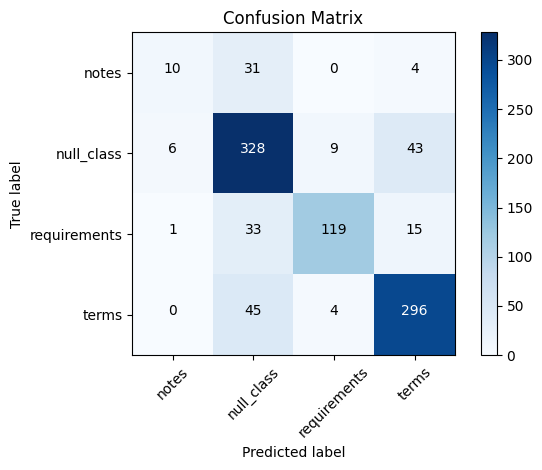

In [50]:
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [51]:
cm

array([[ 10,  31,   0,   4],
       [  6, 328,   9,  43],
       [  1,  33, 119,  15],
       [  0,  45,   4, 296]])

In [ ]:
# exp
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = LogisticRegression(max_iter=2000)

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
param_grid = {
    'C': [0.1, 1, 5, 7, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'class_weight': ['balanced', None]
}

# –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
grid_search.fit(X_train_tfidf, y_train)

# –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
y_pred = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


In [ ]:
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [34]:
df_for_training['label'].value_counts()

null_class      3913
terms           3377
requirements    1646
notes            499
Name: label, dtype: int64

In [35]:
# # –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ç–µ–∫—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö –≤ TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–∏
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # –û–±—É—á–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –Ω–∞ TF-IDF –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö
# classifier = LogisticRegression()
# classifier.fit(X_train_tfidf, y_train)

# # –û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
# accuracy = classifier.score(X_test_tfidf, y_test)
# print("Accuracy:", accuracy)

In [64]:
# # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
# model = LogisticRegression()

# # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
# param_grid = {
#     'C': [0.1, 1, 10],
#     'penalty': ['l1', 'l2']
# }

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏

model = SVC()

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
grid_search.fit(X_train_tfidf, y_train)

# –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
y_pred = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best score: 0.8001419112330332
              precision    recall  f1-score   support

       notes       0.65      0.29      0.40        45
  null_class       0.78      0.85      0.81       386
requirements       0.87      0.73      0.79       168
       terms       0.84      0.88      0.86       345

    accuracy                           0.81       944
   macro avg       0.78      0.69      0.72       944
weighted avg       0.81      0.81      0.81       944



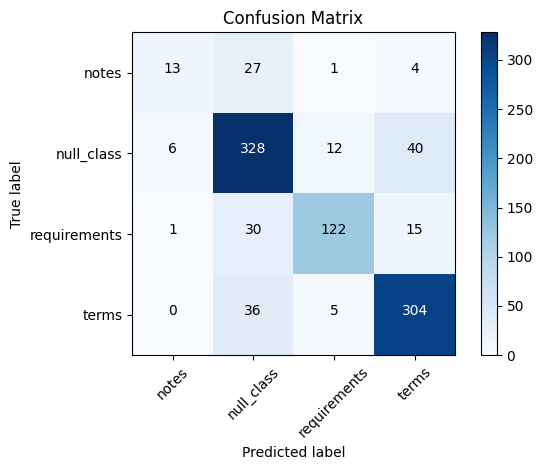

In [66]:
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [51]:
# # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model = SVC()

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
param_grid = {
    'C': [0.1, 1, 3, 6, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
grid_search.fit(X_train_tfidf, y_train)

# –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# –û—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
y_pred = grid_search.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Best parameters: {'C': 1, 'kernel': 'linear'}
Best score: 0.8001419112330332
              precision    recall  f1-score   support

       notes       0.65      0.29      0.40        45
  null_class       0.78      0.85      0.81       386
requirements       0.87      0.73      0.79       168
       terms       0.84      0.88      0.86       345

    accuracy                           0.81       944
   macro avg       0.78      0.69      0.72       944
weighted avg       0.81      0.81      0.81       944



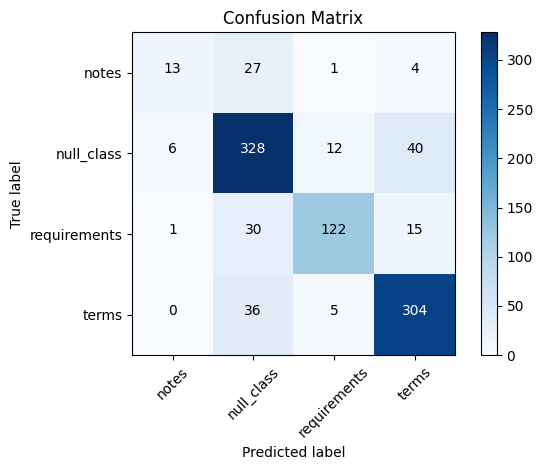

In [53]:
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# # –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –Ω–∞ –æ–±—É—á–∞—é—â–∏–π –∏ —Ç–µ—Å—Ç–æ–≤—ã–π –Ω–∞–±–æ—Ä—ã
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –±—É—Å—Ç–∏–Ω–≥–∞
model = GradientBoostingClassifier()

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
model.fit(X_train_tfidf, y_train)

# –ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
y_pred = model.predict(X_test_tfidf)

# –û—Ü–µ–Ω–∫–∞ —Ç–æ—á–Ω–æ—Å—Ç–∏
y_pred = classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("f1_score:", f1)
print(classification_report(y_test, y_pred))

Accuracy: 0.7976694915254238
f1_score: 0.6887757703159243
              precision    recall  f1-score   support

       notes       0.59      0.22      0.32        45
  null_class       0.75      0.85      0.80       386
requirements       0.90      0.71      0.79       168
       terms       0.83      0.86      0.84       345

    accuracy                           0.80       944
   macro avg       0.77      0.66      0.69       944
weighted avg       0.80      0.80      0.79       944



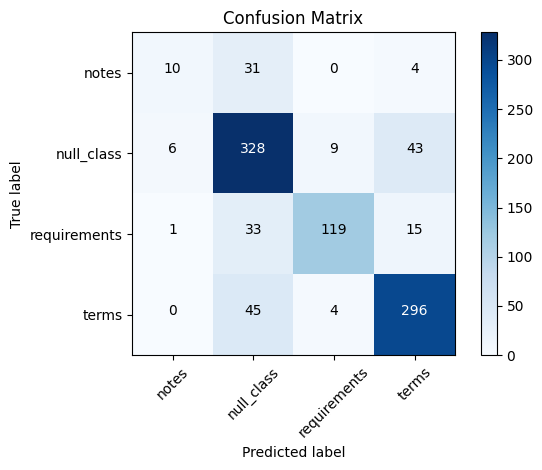

In [39]:
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV

# # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –±—É—Å—Ç–∏–Ω–≥–∞
# model = GradientBoostingClassifier()

# # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'max_depth': [3, 7, 10]
# }

# # –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
# grid_search.fit(X_train_tfidf, y_train)

# # –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

In [56]:
# # –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV



# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
grid_search.fit(X_train_tfidf, y_train)

# –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# –ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
y_pred = grid_search.predict(X_test_tfidf)

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}
Best score: 0.8017908407287319
Accuracy: 0.8008474576271186


In [ ]:
# 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV



# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5, 10, 15]
}

# –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –¥–∞–Ω–Ω—ã—Ö —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
grid_search.fit(X_train_tfidf, y_train)

# –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# –ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–ª–∞—Å—Å–æ–≤ –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
y_pred = grid_search.predict(X_test_tfidf)

# –í—ã—á–∏—Å–ª–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


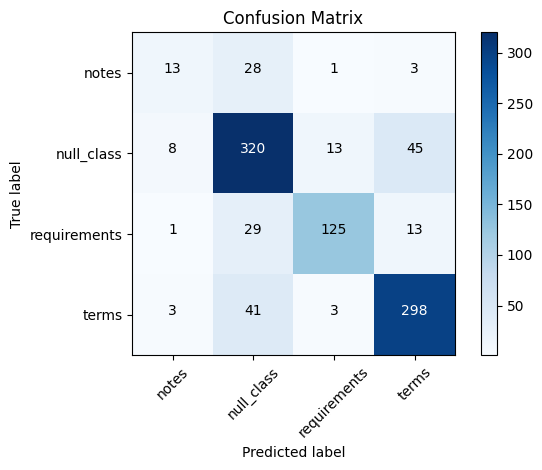

In [ ]:
# –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classifier.classes_)
plt.show()

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV

# # –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
# classifier = KNeighborsClassifier()

# # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
# param_grid = {
#     'n_neighbors': [3, 5, 7, 9]
# }

# # –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
# grid_search = GridSearchCV(classifier, param_grid, cv=5)

# # –û–±—É—á–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
# grid_search.fit(X_train_tfidf, y_train)

# # –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

# # –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –æ–±—É—á–µ–Ω–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–µ—Ç–æ–∫
# y_pred = grid_search.predict(X_test_tfidf)
# # –í—ã—á–∏—Å–ª–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# # –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()


In [ ]:
# # –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [25]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.model_selection import GridSearchCV

# # –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
# classifier = AdaBoostClassifier(random_state=42)

# # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–µ—Ç–∫–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ø–µ—Ä–µ–±–æ—Ä–∞
# param_grid = {
#     'n_estimators': [50, 100, 200]
#     # 'learning_rate': [0.1, 0.5, 1.0]
# }

# # –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ GridSearchCV
# grid_search = GridSearchCV(classifier, param_grid, cv=5)

# # –û–±—É—á–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ —Å –ø–æ–¥–±–æ—Ä–æ–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
# grid_search.fit(X_train_tfidf, y_train)

# # –í—ã–≤–æ–¥ –ª—É—á—à–µ–≥–æ –Ω–∞–±–æ—Ä–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–µ–π –º–µ—Ç—Ä–∏–∫–∏
# print("Best parameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

# # –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –æ–±—É—á–µ–Ω–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–µ—Ç–æ–∫
# y_pred = grid_search.predict(X_test_tfidf)

# # –í—ã—á–∏—Å–ª–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

In [ ]:
# # –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [24]:
# from sklearn.naive_bayes import GaussianNB

# # –°–æ–∑–¥–∞–Ω–∏–µ —ç–∫–∑–µ–º–ø–ª—è—Ä–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
# classifier = GaussianNB()

# # –û–±—É—á–µ–Ω–∏–µ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞
# classifier.fit(X_train_tfidf.toarray(), y_train)

# # –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –æ–±—É—á–µ–Ω–Ω–æ–≥–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä–∞ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è –º–µ—Ç–æ–∫
# y_pred = classifier.predict(X_test_tfidf.toarray())

# # –í—ã—á–∏—Å–ª–µ–Ω–∏–µ —Ç–æ—á–Ω–æ—Å—Ç–∏ –º–æ–¥–µ–ª–∏
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)

# # –ü—Ä–∏–º–µ—Ä –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classifier.classes_)
# plt.show()

In [67]:
# # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –≤ —Ñ–∞–π–ª —Å –ø–æ–º–æ—â—å—é pickle
# with open('model.pkl', 'wb') as f:
#     pickle.dump(classifier, f)

# # c–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ TfidfVectorizer —Å –ø–æ–º–æ—â—å—é pickle
# with open('vectorizer.pkl', 'wb') as file:
#     pickle.dump(tfidf_vectorizer, file)

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ


In [3]:
# –∑–∞–≥—Ä—É–∑–∫–∞
df = pd.read_excel('../data/data.xlsx')


In [4]:
df.head(2)

id name(–Ω–∞–∑–≤–∞–Ω–∏–µ) specialization(—Å–ø–µ—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è)  \
0  9495846     –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫                    –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
1  9495850     –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫                    –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   

           responsibilities(–î–æ–ª–∂–Ω–æ—Å—Ç–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏)  \
0  –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...   
1  –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...   

  requirements(–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é) terms(–£—Å–ª–æ–≤–∏—è)  \
0                                   NaN            NaN   
1                                   NaN            NaN   

  skills(–ö–ª—é—á–µ–≤—ã–µ –Ω–∞–≤—ã–∫–∏)  salary_from salary_to object  ... updated_by  \
0                     NaN       150000    170000    NaN  ...         \N   
1                     NaN       130000    150000    NaN  ...         \N   

     position phone website     email image  unique_code  city_code  \
0  –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   NaN      hh  hh@hh.ru    \N  HH-81058502         \N   
1  –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   NaN      hh  hh@hh.ru    \N  HH-80163818         \N   

   source_id                   link_resource  
0          1  https://hh.ru/vacancy/81058502  
1          1  https://hh.ru/vacancy/80163818  

[2 rows x 35 columns]

In [5]:
# –ø–µ—Ä–µ–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ –¥–ª—è —É–¥–æ—Å—Ç–≤–∞
df = df.rename(
    columns={
        'responsibilities(–î–æ–ª–∂–Ω–æ—Å—Ç–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏)': 'responsibilities',
        'requirements(–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é)': 'requirements',
        'terms(–£—Å–ª–æ–≤–∏—è)': 'terms',
        'notes(–ü—Ä–∏–º–µ—á–∞–Ω–∏—è)': 'notes',
        # vremenno
        ' ': 'id'
    }
)

# –∑–∞–ø–æ–ª–Ω–µ–Ω–∏–µ NaN
df['responsibilities'] = df['responsibilities'].fillna('')
df['requirements'] = df['requirements'].fillna('')
df['terms'] = df['terms'].fillna('')
df['notes'] = df['notes'].fillna('')

# —É–¥–∞–ª–µ–Ω–∏–µ —Å–º–∞–π–ª–æ–≤ –∏ –ø–æ—Å—Ç–æ—Ä–æ–Ω–Ω–∏—Ö —Å–∏–º–≤–æ–ª–æ–≤ - –ø—Ä–µ–ø—Ä–æ—Ü–µ—Å—Å–∏–Ω–≥ –ø–æ –≤—Å–µ–º –Ω—É–∂–Ω—ã–º –∫–æ–ª–æ–Ω–∫–∞–º
df = df.applymap(del_emoji)

In [6]:
# —Ä–∞–∑–±–∏–µ–Ω–∏–µ –≤—Å–µ—Ö —Ç–µ–∫—Å—Ç–æ–≤ –Ω–∞ –æ—Ç–¥–µ–ª—å–Ω—ã–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
df['responsibilities_split'] = df['responsibilities'].apply(split_sentences)

In [7]:
df.head(2)

id name(–Ω–∞–∑–≤–∞–Ω–∏–µ) specialization(—Å–ø–µ—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è)  \
0  9495846     –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫                    –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
1  9495850     –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫                    –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   

                                    responsibilities requirements terms  \
0  –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...                      
1  –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...                      

  skills(–ö–ª—é—á–µ–≤—ã–µ –Ω–∞–≤—ã–∫–∏) salary_from salary_to object  ...    position phone  \
0                     nan      150000    170000    nan  ...  –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   nan   
1                     nan      130000    150000    nan  ...  –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   nan   

  website     email image  unique_code city_code source_id  \
0      hh  hh@hh.ru    \N  HH-81058502        \N         1   
1      hh  hh@hh.ru    \N  HH-80163818        \N         1   

                    link_resource  \
0  https://hh.ru/vacancy/81058502   
1  https://hh.ru/vacancy/80163818   

                              responsibilities_split  
0  [–†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö., –û—á–∏—Å—Ç–Ω—ã—Ö —Å...  
1  [–ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫...  

[2 rows x 36 columns]

In [8]:
# —Å–æ–∑–¥–∞–¥–∏–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –æ—Ç–¥–µ–ª—å–Ω—ã—Ö –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π
sentences_df = pd.DataFrame(columns=['id_text', 'responsibilities_sentence', 'index_sentence'])

# –ø—Ä–æ–π–¥–µ–º –ø–æ –≤—Å–µ–º —Å—Ç—Ä–æ–∫–∞–º –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ –∏ –≤—ã—Ç–∞—â–∏–º –æ—Ç–¥–µ–ª—å–Ω—ã–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
for index, row in df.iterrows():
    id_text = row['id']
    responsibilities_sentence = row['responsibilities_split']

    # –ø—Ä–æ—Ö–æ–¥ –ø–æ –∫–∞–∂–¥–æ–º—É –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—é
    for index_sentence, sentence in enumerate(responsibilities_sentence):
        # –¥–æ–±–∞–≤–ª–µ–Ω–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
        new_row = {
            'id_text': id_text, 
            'responsibilities_sentence': sentence, 
            'index_sentence': index_sentence
        }
        sentences_df.loc[len(sentences_df)] = new_row
    

In [9]:
sentences_df

id_text                          responsibilities_sentence  \
0     9495846                  –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö.   
1     9495846                              –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è—Ö.   
2     9495850  –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...   
3     9495850              –°–±–æ—Ä–∫–∞ –∏ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –∏ –ø–ª–æ—Å–∫–∏—Ö...   
4     9495851                                    –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.   
...       ...                                                ...   
8072  9306892  –¢–†–ï–ë–£–ï–¢–°–Ø –ú–ê–°–¢–ï–† –° –•–û–†–û–®–ò–ú –û–ü–´–¢–û–ú, –û–¢–í–ï–¢–°–¢–í–ï–ù–ù...   
8073  9306892  –ü–æ–∂–∞–ª—É–π—Å—Ç–∞ –æ—Ç–ø—Ä–∞–≤–ª—è–π—Ç–µ –∫—Ä–∞—Ç–∫–æ–µ —Ä–µ–∑—é–º–µ –æ —Å–µ–±–µ –Ω...   
8074  9306892  –£–ß–ï–ù–ò–ö–û–í, –ü–û–ú–ê–ì–ê–ù–û–í, –ü–û–î–ê–í–ê–ù–û–í –ò –° –û–ü–´–¢–û–ú –û–ö–õ–ï...   
8075  9306892  –ü–û–ñ–ê–õ–£–ô–°–¢–ê –ù–ï –¢–†–ê–¢–¨–¢–ï –ù–ò –°–í–û–ï –ù–ò –ù–ê–®–ï –í–†–ï–ú–Ø –ù–ê...   
8076  9306893  –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö–û...   

      index_sentence  
0                  0  
1                  1  
2                  0  
3                  1  
4                  0  
...              ...  
8072               4  
8073               5  
8074               6  
8075               7  
8076               0  

[8077 rows x 3 columns]

In [10]:
# –ø–µ—Ä–µ–Ω–æ—Å –∫–∞—Ä–µ—Ç–∫–∏
del_n = re.compile('\n')               
# html-—Ç–µ–≥–∏
del_tags = re.compile('<[^>]*>')        
# —Å–æ–¥–µ—Ä–∂–∏–º–æ–µ –∫—Ä—É–≥–ª—ã—Ö —Å–∫–æ–±–æ–∫
del_brackets = re.compile('\([^)]*\)')  


In [12]:
stop_words = set(stopwords.words('russian'))  # –ó–∞–º–µ–Ω–∏—Ç–µ 'english' –Ω–∞ —è–∑—ã–∫ –≤–∞—à–µ–≥–æ —Ç–µ–∫—Å—Ç–∞
lemmatizer = WordNetLemmatizer()

In [13]:
sentences_df['text'] = sentences_df['responsibilities_sentence'].apply(preprocess_text)


In [14]:
sentences_df

id_text                          responsibilities_sentence  \
0     9495846                  –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö.   
1     9495846                              –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è—Ö.   
2     9495850  –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...   
3     9495850              –°–±–æ—Ä–∫–∞ –∏ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –∏ –ø–ª–æ—Å–∫–∏—Ö...   
4     9495851                                    –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.   
...       ...                                                ...   
8072  9306892  –¢–†–ï–ë–£–ï–¢–°–Ø –ú–ê–°–¢–ï–† –° –•–û–†–û–®–ò–ú –û–ü–´–¢–û–ú, –û–¢–í–ï–¢–°–¢–í–ï–ù–ù...   
8073  9306892  –ü–æ–∂–∞–ª—É–π—Å—Ç–∞ –æ—Ç–ø—Ä–∞–≤–ª—è–π—Ç–µ –∫—Ä–∞—Ç–∫–æ–µ —Ä–µ–∑—é–º–µ –æ —Å–µ–±–µ –Ω...   
8074  9306892  –£–ß–ï–ù–ò–ö–û–í, –ü–û–ú–ê–ì–ê–ù–û–í, –ü–û–î–ê–í–ê–ù–û–í –ò –° –û–ü–´–¢–û–ú –û–ö–õ–ï...   
8075  9306892  –ü–û–ñ–ê–õ–£–ô–°–¢–ê –ù–ï –¢–†–ê–¢–¨–¢–ï –ù–ò –°–í–û–ï –ù–ò –ù–ê–®–ï –í–†–ï–ú–Ø –ù–ê...   
8076  9306893  –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö–û...   

      index_sentence                                               text  
0                  0                      —Ä–∞–±–æ—Ç–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö  
1                  1                               –æ—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è—Ö  
2                  0  –≥–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞—Ö –∫...  
3                  1                 —Å–±–æ—Ä–∫–∞ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –ø–ª–æ—Å–∫–∏—Ö ...  
4                  0                                     –≤—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã  
...              ...                                                ...  
8072               4  —Ç—Ä–µ–±—É–µ—Ç—Å—è –º–∞—Å—Ç–µ—Ä —Ö–æ—Ä–æ—à–∏–º –æ–ø—ã—Ç–æ–º –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω—ã–π ...  
8073               5  –ø–æ–∂–∞–ª—É–π—Å—Ç–∞ –æ—Ç–ø—Ä–∞–≤–ª—è–π—Ç–µ –∫—Ä–∞—Ç–∫–æ–µ —Ä–µ–∑—é–º–µ –Ω–∞–º —Å–æ–æ–±...  
8074               6  —É—á–µ–Ω–∏–∫–æ–≤ –ø–æ–º–∞–≥–∞–Ω–æ–≤ –ø–æ–¥–∞–≤–∞–Ω–æ–≤ –æ–ø—ã—Ç–æ–º –æ–∫–ª–µ–π–∫–∏ –ø–∞...  
8075               7  –ø–æ–∂–∞–ª—É–π—Å—Ç–∞ —Ç—Ä–∞—Ç—å—Ç–µ —Å–≤–æ–µ –Ω–∞—à–µ –≤—Ä–µ–º—è –ø—É—Å—Ç—ã–µ –ø–µ—Ä–µ...  
8076               0  –æ–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è —Å–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ —Ñ—ç—Å–∫–æ ...  

[8077 rows x 4 columns]

In [15]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –∏–∑ —Ñ–∞–π–ª–∞
with open('../models/model.pkl', 'rb') as f:
    model = pickle.load(f)

# –∑–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ TfidfVectorizer
with open('../models/vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)


In [16]:
sentences_df['text']

0                           —Ä–∞–±–æ—Ç–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö
1                                    –æ—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è—Ö
2       –≥–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞—Ö –∫...
3                      —Å–±–æ—Ä–∫–∞ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –ø–ª–æ—Å–∫–∏—Ö ...
4                                          –≤—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã
                              ...                        
8072    —Ç—Ä–µ–±—É–µ—Ç—Å—è –º–∞—Å—Ç–µ—Ä —Ö–æ—Ä–æ—à–∏–º –æ–ø—ã—Ç–æ–º –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω—ã–π ...
8073    –ø–æ–∂–∞–ª—É–π—Å—Ç–∞ –æ—Ç–ø—Ä–∞–≤–ª—è–π—Ç–µ –∫—Ä–∞—Ç–∫–æ–µ —Ä–µ–∑—é–º–µ –Ω–∞–º —Å–æ–æ–±...
8074    —É—á–µ–Ω–∏–∫–æ–≤ –ø–æ–º–∞–≥–∞–Ω–æ–≤ –ø–æ–¥–∞–≤–∞–Ω–æ–≤ –æ–ø—ã—Ç–æ–º –æ–∫–ª–µ–π–∫–∏ –ø–∞...
8075    –ø–æ–∂–∞–ª—É–π—Å—Ç–∞ —Ç—Ä–∞—Ç—å—Ç–µ —Å–≤–æ–µ –Ω–∞—à–µ –≤—Ä–µ–º—è –ø—É—Å—Ç—ã–µ –ø–µ—Ä–µ...
8076    –æ–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è —Å–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ —Ñ—ç—Å–∫–æ ...
Name: text, Length: 8077, dtype

In [17]:
# –ø—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –∫ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º—É
X_tfidf = tfidf_vectorizer.transform(sentences_df['text'])
y_predict = model.predict(X_tfidf)


In [18]:
sentences_df['labels'] = y_predict

In [19]:
sentences_df['labels'].value_counts()

null_class      3845
terms           3113
requirements     913
notes            206
Name: labels, dtype: int64

In [20]:
sentences_df

id_text                          responsibilities_sentence  \
0     9495846                  –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö.   
1     9495846                              –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è—Ö.   
2     9495850  –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...   
3     9495850              –°–±–æ—Ä–∫–∞ –∏ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –∏ –ø–ª–æ—Å–∫–∏—Ö...   
4     9495851                                    –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.   
...       ...                                                ...   
8072  9306892  –¢–†–ï–ë–£–ï–¢–°–Ø –ú–ê–°–¢–ï–† –° –•–û–†–û–®–ò–ú –û–ü–´–¢–û–ú, –û–¢–í–ï–¢–°–¢–í–ï–ù–ù...   
8073  9306892  –ü–æ–∂–∞–ª—É–π—Å—Ç–∞ –æ—Ç–ø—Ä–∞–≤–ª—è–π—Ç–µ –∫—Ä–∞—Ç–∫–æ–µ —Ä–µ–∑—é–º–µ –æ —Å–µ–±–µ –Ω...   
8074  9306892  –£–ß–ï–ù–ò–ö–û–í, –ü–û–ú–ê–ì–ê–ù–û–í, –ü–û–î–ê–í–ê–ù–û–í –ò –° –û–ü–´–¢–û–ú –û–ö–õ–ï...   
8075  9306892  –ü–û–ñ–ê–õ–£–ô–°–¢–ê –ù–ï –¢–†–ê–¢–¨–¢–ï –ù–ò –°–í–û–ï –ù–ò –ù–ê–®–ï –í–†–ï–ú–Ø –ù–ê...   
8076  9306893  –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö–û...   

      index_sentence                                               text  \
0                  0                      —Ä–∞–±–æ—Ç–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö   
1                  1                               –æ—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ—Ä—É–∂–µ–Ω–∏—è—Ö   
2                  0  –≥–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞—Ö –∫...   
3                  1                 —Å–±–æ—Ä–∫–∞ —É—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å–µ—Ç–æ–∫ –ø–ª–æ—Å–∫–∏—Ö ...   
4                  0                                     –≤—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã   
...              ...                                                ...   
8072               4  —Ç—Ä–µ–±—É–µ—Ç—Å—è –º–∞—Å—Ç–µ—Ä —Ö–æ—Ä–æ—à–∏–º –æ–ø—ã—Ç–æ–º –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω—ã–π ...   
8073               5  –ø–æ–∂–∞–ª—É–π—Å—Ç–∞ –æ—Ç–ø—Ä–∞–≤–ª—è–π—Ç–µ –∫—Ä–∞—Ç–∫–æ–µ —Ä–µ–∑—é–º–µ –Ω–∞–º —Å–æ–æ–±...   
8074               6  —É—á–µ–Ω–∏–∫–æ–≤ –ø–æ–º–∞–≥–∞–Ω–æ–≤ –ø–æ–¥–∞–≤–∞–Ω–æ–≤ –æ–ø—ã—Ç–æ–º –æ–∫–ª–µ–π–∫–∏ –ø–∞...   
8075               7  –ø–æ–∂–∞–ª—É–π—Å—Ç–∞ —Ç—Ä–∞—Ç—å—Ç–µ —Å–≤–æ–µ –Ω–∞—à–µ –≤—Ä–µ–º—è –ø—É—Å—Ç—ã–µ –ø–µ—Ä–µ...   
8076               0  –æ–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è —Å–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ —Ñ—ç—Å–∫–æ ...   

          labels  
0     null_class  
1     null_class  
2     null_class  
3     null_class  
4     null_class  
...          ...  
8072  null_class  
8073  null_class  
8074  null_class  
8075  null_class  
8076  null_class  

[8077 rows x 5 columns]

In [21]:
sentences_df.columns

Index(['id_text', 'responsibilities_sentence', 'index_sentence', 'text',
       'labels'],
      dtype='object')

In [22]:
def merge_responsibilities(group):
    sorted_group = group.sort_values('index_sentence')
    merged_responsibilities = ' '.join(sorted_group['responsibilities_sentence'])
    return merged_responsibilities

    
df_by_group = sentences_df.groupby(['id_text', 'labels']).apply(merge_responsibilities).reset_index(name='text')

In [23]:
df_by_group


id_text        labels                                               text
0       12933    null_class  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π —Å–≤–∞—Ä–∫–∏ –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –ø—Ä–æ...
1       13376    null_class  –¢—Ä–µ–±—É—é—Ç—Å—è –ë–ï–¢–û–ù–©–ò–ö–ò /–ê–†–ú–ê–¢–£–†–©–ò–ö–ò –∏ —Ä–∞–±–æ—á–∏–µ —Å–ø–µ...
2       13387  requirements  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:\n‚Ä¢ –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ —Å–≤–∞—Ä–æ—á–Ω—ã–º —Ä–∞–±–æ—Ç–∞–º...
3       13674    null_class  —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –ñ–ö "–°–º–∞—Ä—Ç –°–ò–¢–ò" –ø. –ù–æ–≤–∏–Ω–∫–∏_x000D...
4       13706    null_class  –ü—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏–µ —Ä–∞—Å—Ç–≤–æ—Ä–æ–≤ –∏–∑ —Å—É—Ö–∏—Ö —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö ...
...       ...           ...                                                ...
2495  9499939    null_class  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –º–æ—Å—Ç–æ–≤—ã–º–∏ –∫—Ä–∞–Ω–∞–º–∏ –≥—Ä—É–∑...
2496  9500588    null_class  –ü–æ–ª–Ω—ã–π —Ü–∏–∫–ª –º–∞–ª—è—Ä–Ω—ã—Ö —Ä–∞–±–æ—Ç –ø–æ –º–∞—Å—Å–∏–≤—É, –ú–î–§, —à–ø...
2497  9500588         terms  –û—Ç–ª–∏—á–Ω–æ–µ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–µ –æ—Å–Ω–∞—â–µ–Ω–∏–µ –º–∞–ª—è—Ä–Ω–æ–≥–æ —Ü–µ—Ö–∞....
2498  9501565    null_class  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –º–µ—Ö–∞–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ä–∞–±–æ—Ç –ø–æ —É–ø–ª–æ—Ç–Ω–µ–Ω–∏...
2499  9504091    null_class  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –æ—Ç–¥–µ–ª–æ—á–Ω—ã—Ö —Ä–∞–±–æ—Ç: —à—Ç—É–∫–∞—Ç—É—Ä–Ω—ã–µ, –º–∞–ª—è...

[2500 rows x 3 columns]

In [24]:
df_by_group.head(2)

id_text      labels                                               text
0   12933  null_class  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π —Å–≤–∞—Ä–∫–∏ –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –ø—Ä–æ...
1   13376  null_class  –¢—Ä–µ–±—É—é—Ç—Å—è –ë–ï–¢–û–ù–©–ò–ö–ò /–ê–†–ú–ê–¢–£–†–©–ò–ö–ò –∏ —Ä–∞–±–æ—á–∏–µ —Å–ø–µ...

In [25]:
df_encoded = pd.get_dummies(df_by_group['labels'])
merged_df = pd.concat([df_by_group[['id_text', 'text']], df_encoded], axis=1)
merged_df

id_text                                               text  notes  \
0       12933  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π —Å–≤–∞—Ä–∫–∏ –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –ø—Ä–æ...      0   
1       13376  –¢—Ä–µ–±—É—é—Ç—Å—è –ë–ï–¢–û–ù–©–ò–ö–ò /–ê–†–ú–ê–¢–£–†–©–ò–ö–ò –∏ —Ä–∞–±–æ—á–∏–µ —Å–ø–µ...      0   
2       13387  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:\n‚Ä¢ –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ —Å–≤–∞—Ä–æ—á–Ω—ã–º —Ä–∞–±–æ—Ç–∞–º...      0   
3       13674  —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –ñ–ö "–°–º–∞—Ä—Ç –°–ò–¢–ò" –ø. –ù–æ–≤–∏–Ω–∫–∏_x000D...      0   
4       13706  –ü—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏–µ —Ä–∞—Å—Ç–≤–æ—Ä–æ–≤ –∏–∑ —Å—É—Ö–∏—Ö —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö ...      0   
...       ...                                                ...    ...   
2495  9499939  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –£–ø—Ä–∞–≤–ª–µ–Ω–∏–µ –º–æ—Å—Ç–æ–≤—ã–º–∏ –∫—Ä–∞–Ω–∞–º–∏ –≥—Ä—É–∑...      0   
2496  9500588  –ü–æ–ª–Ω—ã–π —Ü–∏–∫–ª –º–∞–ª—è—Ä–Ω—ã—Ö —Ä–∞–±–æ—Ç –ø–æ –º–∞—Å—Å–∏–≤—É, –ú–î–§, —à–ø...      0   
2497  9500588  –û—Ç–ª–∏—á–Ω–æ–µ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–µ –æ—Å–Ω–∞—â–µ–Ω–∏–µ –º–∞–ª—è—Ä–Ω–æ–≥–æ —Ü–µ—Ö–∞....      0   
2498  9501565  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –º–µ—Ö–∞–Ω–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö —Ä–∞–±–æ—Ç –ø–æ —É–ø–ª–æ—Ç–Ω–µ–Ω–∏...      0   
2499  9504091  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –æ—Ç–¥–µ–ª–æ—á–Ω—ã—Ö —Ä–∞–±–æ—Ç: —à—Ç—É–∫–∞—Ç—É—Ä–Ω—ã–µ, –º–∞–ª—è...      0   

      null_class  requirements  terms  
0              1             0      0  
1              1             0      0  
2              0             1      0  
3              1             0      0  
4              1             0      0  
...          ...           ...    ...  
2495           1             0      0  
2496           1             0      0  
2497           0             0      1  
2498           1             0      0  
2499           1             0      0  

[2500 rows x 6 columns]

In [26]:
merged_df['notes'] = merged_df.apply(lambda row: row['text'] if row['notes'] == 1 else '', axis=1)
merged_df['null_class'] = merged_df.apply(lambda row: row['text'] if row['null_class'] == 1 else '', axis=1)
merged_df['requirements'] = merged_df.apply(lambda row: row['text'] if row['requirements'] == 1 else '', axis=1)
merged_df['terms'] = merged_df.apply(lambda row: row['text'] if row['terms'] == 1 else '', axis=1)

merged_df.head()


id_text                                               text notes  \
0   12933  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π —Å–≤–∞—Ä–∫–∏ –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –ø—Ä–æ...         
1   13376  –¢—Ä–µ–±—É—é—Ç—Å—è –ë–ï–¢–û–ù–©–ò–ö–ò /–ê–†–ú–ê–¢–£–†–©–ò–ö–ò –∏ —Ä–∞–±–æ—á–∏–µ —Å–ø–µ...         
2   13387  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:\n‚Ä¢ –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ —Å–≤–∞—Ä–æ—á–Ω—ã–º —Ä–∞–±–æ—Ç–∞–º...         
3   13674  —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –ñ–ö "–°–º–∞—Ä—Ç –°–ò–¢–ò" –ø. –ù–æ–≤–∏–Ω–∫–∏_x000D...         
4   13706  –ü—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏–µ —Ä–∞—Å—Ç–≤–æ—Ä–æ–≤ –∏–∑ —Å—É—Ö–∏—Ö —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö ...         

                                          null_class  \
0  –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π —Å–≤–∞—Ä–∫–∏ –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –ø—Ä–æ...   
1  –¢—Ä–µ–±—É—é—Ç—Å—è –ë–ï–¢–û–ù–©–ò–ö–ò /–ê–†–ú–ê–¢–£–†–©–ò–ö–ò –∏ —Ä–∞–±–æ—á–∏–µ —Å–ø–µ...   
2                                                      
3  —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –ñ–ö "–°–º–∞—Ä—Ç –°–ò–¢–ò" –ø. –ù–æ–≤–∏–Ω–∫–∏_x000D...   
4  –ü—Ä–∏–≥–æ—Ç–æ–≤–ª–µ–Ω–∏–µ —Ä–∞—Å—Ç–≤–æ—Ä–æ–≤ –∏–∑ —Å—É—Ö–∏—Ö —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö ...   

                                        requirements terms  
0                                                           
1                                                           
2  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:\n‚Ä¢ –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ —Å–≤–∞—Ä–æ—á–Ω—ã–º —Ä–∞–±–æ—Ç–∞–º...        
3                                                           
4

In [27]:
grouped_df = merged_df.groupby('id_text').sum().reset_index()
grouped_df = grouped_df[['id_text', 'requirements', 'terms', 'notes','null_class']]
grouped_df.rename(columns={
    'requirements': 'requirements(–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é)',
    'terms': 'terms(–£—Å–ª–æ–≤–∏—è)',
    'notes': 'notes(–ü—Ä–∏–º–µ—á–∞–Ω–∏—è)', 
    'null_class': 'null_class(–æ—Å—Ç–∞—Ç–∫–∏ –æ—Ç –î–æ–ª–∂ –æ–±—è–∑)',
    'id_text': 'id'
}, inplace=True)

grouped_df['id'] = grouped_df['id'].astype(int)

grouped_df.head(3)


id              requirements(–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é) terms(–£—Å–ª–æ–≤–∏—è)  \
0  12933                                                                     
1  13376                                                                     
2  13387  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:\n‚Ä¢ –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ —Å–≤–∞—Ä–æ—á–Ω—ã–º —Ä–∞–±–æ—Ç–∞–º...                  

  notes(–ü—Ä–∏–º–µ—á–∞–Ω–∏—è)                   null_class(–æ—Å—Ç–∞—Ç–∫–∏ –æ—Ç –î–æ–ª–∂ –æ–±—è–∑)  
0                    –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ –∫–∞—á–µ—Å—Ç–≤–µ–Ω–Ω–æ–π —Å–≤–∞—Ä–∫–∏ –≤ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –ø—Ä–æ...  
1                    –¢—Ä–µ–±—É—é—Ç—Å—è –ë–ï–¢–û–ù–©–ò–ö–ò /–ê–†–ú–ê–¢–£–†–©–ò–ö–ò –∏ —Ä–∞–±–æ—á–∏–µ —Å–ø–µ...  
2

In [28]:
# –∑–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–≥–æ –º–µ—Ä–∂–∞
df = pd.read_excel('../data/data.xlsx')

# —É–¥–∞–ª–∏–º –∫–æ–ª–æ–Ω–∫–∏, —á—Ç–æ–±—ã –Ω–µ –¥—É–±–ª–∏—Ä–æ–≤–∞–ª–∏—Å—å
df.drop(
    [
        'notes(–ü—Ä–∏–º–µ—á–∞–Ω–∏—è)', 
        'requirements(–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é)', 
        'terms(–£—Å–ª–æ–≤–∏—è)'
    ], 
    axis=1, 
    inplace=True
)


In [29]:
full_df = df.merge(grouped_df, on='id', how='left')


In [30]:
full_df

id     name(–Ω–∞–∑–≤–∞–Ω–∏–µ)  \
0    9495846         –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
1    9495850         –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
2    9495851         –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
3          2         –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
4    9388857         –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
..       ...                ...   
994  9306889            –ò–Ω–∂–µ–Ω–µ—Ä   
995  9306890          –ú–æ–Ω—Ç–∞–∂–Ω–∏–∫   
996  9306891  –°–ª–µ—Å–∞—Ä—å-–†–µ–º–æ–Ω—Ç–Ω–∏–∫   
997  9306892         –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
998  9306893  –°–ª–µ—Å–∞—Ä—å-–†–µ–º–æ–Ω—Ç–Ω–∏–∫   

                         specialization(—Å–ø–µ—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è)  \
0                                           –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
1                                           –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
2                                           –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
3                                           –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫   
4    –ê—Ä–º–∞—Ç—É—Ä—â–∏–∫ –í–∞—Ö—Ç–∞ –≤ –ºc–∫ (–ø–∏—Ç–∞–Ω–∏–µ+–ø—Ä–æ–∂–∏–≤–∞–Ω–∏–µ) 60/30   
..                                                 ...   
994                                –ò–Ω–∂–µ–Ω–µ—Ä –∫–æ–Ω—Å—Ç—Ä—É–∫—Ç–æ—Ä   
995                  –ú–æ–Ω—Ç–∞–∂–Ω–∏–∫ –≤–µ–Ω—Ç–∏–ª—è—Ü–∏–∏/—Ä–∞–∑–Ω–æ—Ä–∞–±–æ—á–∏–π   
996    –°–ª–µ—Å–∞—Ä—å - –∞–≤—Ç–æ–º–µ—Ö–∞–Ω–∏–∫ –≤ —Ü–µ—Ö –ø–æ —Ä–µ–º–æ–Ω—Ç—É –∫–∞—Ä–¥–∞–Ω–æ–≤   
997  –û–∫–ª–µ–π—â–∏–∫ –∞–≤—Ç–æ–º–æ–±–∏–ª–µ–π, –ø–æ–ª–∏—É—Ä–µ—Ç–∞–Ω –≤–∏–Ω–∏–ª, –∞—Ä–º–∞—Ç—É...   
998                      –°–ª–µ—Å–∞—Ä—å-—Ä–µ–º–æ–Ω—Ç–Ω–∏–∫ 5-6 —Ä–∞–∑—Ä—è–¥–∞   

             responsibilities(–î–æ–ª–∂–Ω–æ—Å—Ç–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏)  \
0    –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...   
1    –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...   
2                                      –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.   
3    –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π ...   
4    –í–∞—Ö—Ç–∞ –≤ –≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞.  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - –∞—Ä–º–∏—Ä–æ–≤–∞...   
..                                                 ...   
994  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –ü—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —É–ª—å—Ç—Ä–∞–∑–≤—É–∫–æ–≤—ã—Ö –ø—Ä–µ...   
995  –í–Ω–∏–º–∞–Ω–∏–µ –ø–æ–∫–∞ –æ–±—å—è–≤–ª–µ–Ω–∏–µ –≤–∏—Å–∏—Ç, –≤–µ–¥–µ—Ç—Å—è –Ω–∞–±–æ—Ä!...   
996  –¢—Ä–µ–±—É–µ—Ç—Å—è —Å–ª–µ—Å–∞—Ä—å –≤ —Ü–µ—Ö –ø–æ —Ä–µ–º–æ–Ω—Ç—É –∏ –±–∞–ª–∞–Ω—Å–∏—Ä–æ...   
997  üî• –ö –Ω–∞–º –≤ –∫–æ–º–∞–Ω–¥—É —Ç—Ä–µ–±—É—é—Ç—Å—è:  üî∏ –ú–∞—Å—Ç–µ—Ä –ø–æ –æ–∫–ª–µ...   
998  –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö–û...   

    skills(–ö–ª—é—á–µ–≤—ã–µ –Ω–∞–≤—ã–∫–∏)  salary_from salary_to                 object  \
0                       NaN       150000    170000                    NaN   
1                       NaN       130000    150000                    NaN   
2                       NaN        85000     90000                    NaN   
3                        \N        50000    100000  –û–û–û "–ê–õ–¨–ú–ò–°_–ò–ù–¢–ï–ì–†–ê–õ"   
4                       NaN        67000    134000                    NaN   
..                      ...          ...       ...                    ...   
994                     NaN        35000     35000                    NaN   
995                     NaN         1800     46800                    NaN   
996                     NaN        50000     50000                    NaN   
997                     NaN       120000    200000                    NaN   
998                     NaN        45000     45000                    NaN   

                city                                            address  ...  \
0       –î–∏–º–∏—Ç—Ä–æ–≤–≥—Ä–∞–¥                                       –î–∏–º–∏—Ç—Ä–æ–≤–≥—Ä–∞–¥  ...   
1            –ö–æ–ø–µ–π—Å–∫                                            –ö–æ–ø–µ–π—Å–∫  ...   
2          –Ø—Ä–æ—Å–ª–∞–≤–ª—å                                          –Ø—Ä–æ—Å–ª–∞–≤–ª—å  ...   
3                 \N  119048,¬†–≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞,¬†—É–ª –õ—É–∂–Ω–∏–∫–∏, –¥. 24 —Å—Ç—Ä. 9...  ...   
4          

In [31]:
full_df.to_excel('../data/data_results.xlsx')

In [ ]:
# –¥–∞–ª–µ–µ —á–µ—Ä–Ω–æ–≤–∏–∫

In [20]:
# # –ø–ª–∞–Ω—ã –Ω–∞ –º–µ—Ç—Ä–∏–∫–∏
# Rouge - –ø–æ –ø–µ—Ä–µ–∫—Ä—ã—Ç–∏—è–º  —Å–ª–æ–≤
# BLEU - –ø–µ—Ä–µ–∫—Ä—ã—Ç–∏–µ n-–≥—Ä–∞–º–º –º–µ–∂–¥—É –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω—ã–º–∏ –∏ —ç—Ç–∞–ª–æ–Ω–Ω—ã–º–∏ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è–º–∏
# –∫–æ—Å–∏–Ω—É—Å–Ω–æ–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–µ (—Ç–æ–ª—å–∫–æ —Å–Ω–∞—á–∞–ª–∞ –≤ –≤–µ–∫—Ç–æ—Ä –Ω—É–∂–Ω–æ)
# Sequence Alignment  - –≤—ã—Ä–∞–≤–Ω–∏–≤–∞–Ω–∏–µ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ (–≤ –î–ù–ö –∏—Å–ø–æ–ª—å–∑—É—é—Ç)

In [73]:
df

responsibilities  \
2     –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...   
3     –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...   
4                                       –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.   
5     –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π ...   
6     –í–∞—Ö—Ç–∞ –≤ –≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞.  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - –∞—Ä–º–∏—Ä–æ–≤–∞...   
...                                                 ...   
996   –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –ü—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —É–ª—å—Ç—Ä–∞–∑–≤—É–∫–æ–≤—ã—Ö –ø—Ä–µ...   
997   –í–Ω–∏–º–∞–Ω–∏–µ –ø–æ–∫–∞ –æ–±—å—è–≤–ª–µ–Ω–∏–µ –≤–∏—Å–∏—Ç, –≤–µ–¥–µ—Ç—Å—è –Ω–∞–±–æ—Ä!...   
998   –¢—Ä–µ–±—É–µ—Ç—Å—è —Å–ª–µ—Å–∞—Ä—å –≤ —Ü–µ—Ö –ø–æ —Ä–µ–º–æ–Ω—Ç—É –∏ –±–∞–ª–∞–Ω—Å–∏—Ä–æ...   
999    –ö –Ω–∞–º –≤ –∫–æ–º–∞–Ω–¥—É —Ç—Ä–µ–±—É—é—Ç—Å—è:   –ú–∞—Å—Ç–µ—Ä –ø–æ –æ–∫–ª–µ–π–∫...   
1000  –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö–û...   

                                           requirements  \
2                                                         
3                                                         
4                                                         
5     –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π ...   
6     –æ–ø—ã—Ç –≤ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–µ –ø—Ä–∏–≤–µ—Ç—Å—Ç–≤—É–µ—Ç—Å—è; —Ä–∞–±–æ—Ç–∞ –≤ ...   
...                                                 ...   
996                                                       
997   –ü—Ä–∏–≤–µ—Ç—Å—Ç–≤—É–µ—Ç—Å—è –æ–ø—ã—Ç –ø–æ —É—Å—Ç–∞–Ω–æ–≤–∫–µ —Å–∏—Å—Ç–µ–º –∫–æ–Ω–¥–∏—Ü...   
998   –û–±—É—á–∞–µ–º. –¢–æ–∫–∞—Ä–Ω—ã–µ –Ω–∞–≤—ã–∫–∏ –∏ —Å–≤–∞—Ä–æ—á–Ω—ã–µ –Ω–∞–≤—ã–∫–∏ –ø—Ä...   
999   –ø—ã—Ç —Ä–∞–±–æ—Ç—ã, –∑–Ω–∞–Ω–∏–µ –∏ –ø–æ–Ω–∏–º–∞–Ω–∏–µ –ø—Ä–∏–Ω—Ü–∏–ø–æ–≤ —Ä–∞–±–æ—Ç...   
1000                                         —Ä–∞–∑—Ä—è–¥ 5-6   

                                                  terms  \
2                                                         
3                                                         
4                                                         
5                                                         
6     –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤–∞—Ö—Ç—ã 60/30 (–ø—Ä–æ–¥–ª–µ–Ω–∏–µ –≤–∞—Ö—Ç—ã...   
...                                                 ...   
996                                     –æ—Ñ–∏—Å–Ω—ã–µ —É—Å–ª–æ–≤–∏—è   
997    –û–ø–ª–∞—Ç–∞ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç—Å—è —Ä–∞–∑ –≤ –Ω–µ–¥–µ–ª—é –ø–æ —Å—É–±–±–æ—Ç–∞–º!...   
998                –ó–∞—Ä–ø–ª–∞—Ç–∞, –≥—Ä–∞—Ñ–∏–∫ —Ä–∞–±–æ—Ç—ã –æ–±—Å—É–∂–¥–∞—é—Ç—Å—è.   
999                                                       
1000  5/2 - 8 —á–∞—Å–æ–≤—ã–µ —Å–º–µ–Ω—ã, –≤ —Ç.—á. –≤ –Ω–æ—á—å, –∑/–ø –ø–æ –∫...   

                                                  notes  
2     –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...  
3                                                        
4                                                        
5                                                    \N  
6     –û—Ñ–∏—Ü–∏–∞–ª—å–Ω–æ–µ —Ç—Ä—É–¥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ; - –ó–ü –≤ —Å—Ä–æ–∫ –∏ –±–µ–∑...  
...                                                 ...  
996                                                      
997                                                      
998                                                      
999                                                      
1000                                                     

[999 rows x 4 columns]

In [43]:
# pd.set_option('display.max_columns', None)
# df['skills(–ö–ª—é—á–µ–≤—ã–µ –Ω–∞–≤—ã–∫–∏)'].unique()
# df[df['skills(–ö–ª—é—á–µ–≤—ã–µ –Ω–∞–≤—ã–∫–∏)'] == '—Ç—Ä—É–¥–æ–ª—é–±–∏–µ –∏ –∏—Å–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å']
# df['type_of_employment_id(–¢–∏–ø –∑–∞–Ω—è—Ç–æ—Å—Ç–∏)'].unique()

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 2 to 1000
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   responsibilities  999 non-null    object
 1   requirements      828 non-null    object
 2   terms             902 non-null    object
 3   notes             207 non-null    object
dtypes: object(4)
memory usage: 31.3+ KB


In [175]:
pd.set_option('display.max_rows', None)


In [ ]:
df[['responsibilities', 'prepr']]

In [128]:
# —Ç–∞–∫ –æ—Ç–±—Ä–æ—Å–∏–º —Ç–µ, —É –∫–æ—Ç–æ—Ä—ã—Ö –Ω–µ—Ç –Ω–∏ —É—Å–ª–æ–≤–∏–π, –Ω–∏ —Ç—Ä–µ–±–æ–≤–∞–Ω–∏–π, –Ω–∏ –ø—Ä–∏–º–µ—á–∞–Ω–∏–π
df[
    (~df['requirements'].isna()) |
    (~df['terms'].isna()) |
    (~df['notes'].isna())
]

responsibilities  \
2     –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...   
5     –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π ...   
6     –í–∞—Ö—Ç–∞ –≤ –≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞.  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - –∞—Ä–º–∏—Ä–æ–≤–∞...   
7     –¢—Ä–µ–±—É–µ—Ç—Å—è –ê–†–ú–ê–¢–£–†–©–ò–ö –Ω–∞ –∫—Ä—É–ø–Ω–µ–π—à–∏–π –∑–∞–≤–æ–¥ –ø–æ –ø—Ä...   
8     –ü–æ—á–µ–ø—Ç–∞ –î–∞–ª—å–Ω–µ–≤–æ—Å—Ç–æ—á–Ω–æ–π –∂–µ–ª–µ–∑–Ω–æ–π –¥–æ—Ä–æ–≥–∏  –ú–æ—Å—Ç ...   
...                                                 ...   
996   –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –ü—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —É–ª—å—Ç—Ä–∞–∑–≤—É–∫–æ–≤—ã—Ö –ø—Ä–µ...   
997   –í–Ω–∏–º–∞–Ω–∏–µ –ø–æ–∫–∞ –æ–±—å—è–≤–ª–µ–Ω–∏–µ –≤–∏—Å–∏—Ç, –≤–µ–¥–µ—Ç—Å—è –Ω–∞–±–æ—Ä!...   
998   –¢—Ä–µ–±—É–µ—Ç—Å—è —Å–ª–µ—Å–∞—Ä—å –≤ —Ü–µ—Ö –ø–æ —Ä–µ–º–æ–Ω—Ç—É –∏ –±–∞–ª–∞–Ω—Å–∏—Ä–æ...   
999   üî• –ö –Ω–∞–º –≤ –∫–æ–º–∞–Ω–¥—É —Ç—Ä–µ–±—É—é—Ç—Å—è:  üî∏ –ú–∞—Å—Ç–µ—Ä –ø–æ –æ–∫–ª–µ...   
1000  –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö–û...   

                                           requirements  \
2                                                   NaN   
5     –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π ...   
6     –æ–ø—ã—Ç –≤ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–µ –ø—Ä–∏–≤–µ—Ç—Å—Ç–≤—É–µ—Ç—Å—è; —Ä–∞–±–æ—Ç–∞ –≤ ...   
7     –û–ø—ã—Ç —Ä–∞–±–æ—Ç—ã –æ—Ç 1 –≥–æ–¥–∞ , –Ω–∞–ª–∏—á–∏–µ —É–¥–æ—Å—Ç–æ–≤–µ—Ä–µ–Ω–∏—è ...   
8     –æ–ø—ã—Ç –≤ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–µ –ø—Ä–∏–≤–µ—Ç—Å—Ç–≤—É–µ—Ç—Å—è -—Ä–∞–±–æ—Ç–∞ –≤ ...   
...                                                 ...   
996                                                 NaN   
997   –ü—Ä–∏–≤–µ—Ç—Å—Ç–≤—É–µ—Ç—Å—è –æ–ø—ã—Ç –ø–æ —É—Å—Ç–∞–Ω–æ–≤–∫–µ —Å–∏—Å—Ç–µ–º –∫–æ–Ω–¥–∏—Ü...   
998   –û–±—É—á–∞–µ–º. –¢–æ–∫–∞—Ä–Ω—ã–µ –Ω–∞–≤—ã–∫–∏ –∏ —Å–≤–∞—Ä–æ—á–Ω—ã–µ –Ω–∞–≤—ã–∫–∏ –ø—Ä...   
999   –ø—ã—Ç —Ä–∞–±–æ—Ç—ã, –∑–Ω–∞–Ω–∏–µ –∏ –ø–æ–Ω–∏–º–∞–Ω–∏–µ –ø—Ä–∏–Ω—Ü–∏–ø–æ–≤ —Ä–∞–±–æ—Ç...   
1000                                         —Ä–∞–∑—Ä—è–¥ 5-6   

                                                  terms  \
2                                                   NaN   
5                                                   NaN   
6     –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤–∞—Ö—Ç—ã 60/30 (–ø—Ä–æ–¥–ª–µ–Ω–∏–µ –≤–∞—Ö—Ç—ã...   
7     –ñ–µ–ª–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–∞—Ç—å –∏ –∑–∞—Ä–∞–±–∞—Ç—ã–≤–∞—Ç—å –£—Å–ª–æ–≤–∏—è:  –†–∞–±–æ...   
8     –ø—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤–∞—Ö—Ç—ã 60/30 (–ø—Ä–æ–¥–ª–µ–Ω–∏–µ –≤–∞—Ö—Ç—ã...   
...                                                 ...   
996                                     –æ—Ñ–∏—Å–Ω—ã–µ —É—Å–ª–æ–≤–∏—è   
997    –û–ø–ª–∞—Ç–∞ –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç—Å—è —Ä–∞–∑ –≤ –Ω–µ–¥–µ–ª—é –ø–æ —Å—É–±–±–æ—Ç–∞–º!...   
998                –ó–∞—Ä–ø–ª–∞—Ç–∞, –≥—Ä–∞—Ñ–∏–∫ —Ä–∞–±–æ—Ç—ã –æ–±—Å—É–∂–¥–∞—é—Ç—Å—è.   
999                                                 NaN   
1000  5/2 - 8 —á–∞—Å–æ–≤—ã–µ —Å–º–µ–Ω—ã, –≤ —Ç.—á. –≤ –Ω–æ—á—å, –∑/–ø –ø–æ –∫...   

                                                  notes  
2     –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...  
5                                                    \N  
6     –û—Ñ–∏—Ü–∏–∞–ª—å–Ω–æ–µ —Ç—Ä—É–¥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ; - –ó–ü –≤ —Å—Ä–æ–∫ –∏ –±–µ–∑...  
7     –°—Ç–∞–≤–∫–∞ –∑–∞ —Å–º–µ–Ω—É 3080 —Ä—É–± –ø—Ä–∏ –≥—Ä–∞—Ñ–∏–∫–µ 6/1 –ø–æ 11...  
8      –û—Ñ–∏—Ü–∏–∞–ª—å–Ω–æ–µ —Ç—Ä—É–¥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ; - –ó–ü –≤ —Å—Ä–æ–∫ –∏ –±–µ...  
...                                                 ...  
996                                                 NaN  
997                                                 NaN  
998                                                 NaN  
999                                                 NaN  
1000                                                NaN  

[982 rows x 4 columns]

In [149]:
# df[df['terms'].fillna('').str.contains('N')]
# df[~df['terms'].isna() & df['terms'].str.contains('N')]

# df[df['notes'].fillna('').str.contains('N')]

In [7]:
df['responsibilities'].apply(lambda x: len(x))

2        55
3       140
4        15
5       190
6       621
       ... 
996     220
997     292
998     413
999     868
1000    209
Name: responsibilities, Length: 999, dtype: int64

In [20]:
df['tokens'] = df['responsibilities'].apply(sent_tokenize)

In [35]:
df['tokens'].apply(len).sum()

7647

In [8]:
len_responsibilities = df['responsibilities'].apply(sent_tokenize).apply(len).sum()
len_requirements = df['requirements'].apply(sent_tokenize).apply(len).sum()
len_terms = df['terms'].apply(sent_tokenize).apply(len).sum()
len_notes = df['notes'].apply(sent_tokenize).apply(len).sum()

print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û:', len_responsibilities)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°:', len_requirements)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£: ', len_terms)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä:', len_notes)
print('–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:        ', len_requirements + len_terms + len_notes)

–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û: 7652
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°: 1444
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£:  3207
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä: 502
–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:         5153


In [78]:
len_responsibilities = df['responsibilities'].apply(sent_tokenize).apply(len).sum()
len_requirements = df['requirements'].apply(sent_tokenize).apply(len).sum()
len_terms = df['terms'].apply(sent_tokenize).apply(len).sum()
len_notes = df['notes'].apply(sent_tokenize).apply(len).sum()

print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û:', len_responsibilities)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°:', len_requirements)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£: ', len_terms)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä:', len_notes)
print('–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:        ', len_requirements + len_terms + len_notes)

–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û: 7647
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°: 1444
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£:  3207
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä: 501
–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:         5152


In [4]:
df['responsibilities']

2       –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...
3       –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...
4                                         –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.
5       –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π ...
6       –í–∞—Ö—Ç–∞ –≤ –≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞.  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - –∞—Ä–º–∏—Ä–æ–≤–∞...
                              ...                        
996     –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –ü—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —É–ª—å—Ç—Ä–∞–∑–≤—É–∫–æ–≤—ã—Ö –ø—Ä–µ...
997     –í–Ω–∏–º–∞–Ω–∏–µ –ø–æ–∫–∞ –æ–±—å—è–≤–ª–µ–Ω–∏–µ –≤–∏—Å–∏—Ç, –≤–µ–¥–µ—Ç—Å—è –Ω–∞–±–æ—Ä!...
998     –¢—Ä–µ–±—É–µ—Ç—Å—è —Å–ª–µ—Å–∞—Ä—å –≤ —Ü–µ—Ö –ø–æ —Ä–µ–º–æ–Ω—Ç—É –∏ –±–∞–ª–∞–Ω—Å–∏—Ä–æ...
999      –ö –Ω–∞–º –≤ –∫–æ–º–∞–Ω–¥—É —Ç—Ä–µ–±—É—é—Ç—Å—è:   –ú–∞—Å—Ç–µ—Ä –ø–æ –æ–∫–ª–µ–π–∫...
1000    –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö–û.

In [ ]:
# for index, row in tqdm(df.iterrows()):
#     # –†–∞–∑–±–∏–µ–Ω–∏–µ —Ç–µ–∫—Å—Ç–æ–≤ –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è
#     responsibilities = sent_tokenize(str(row['–î–æ–ª–∂–Ω–æ—Å—Ç–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏']))
#     conditions = sent_tokenize(str(row['–£—Å–ª–æ–≤–∏—è']))
#     requirements = sent_tokenize(str(row['–¢—Ä–µ–±–æ–≤–∞–Ω–∏–µ –∫ —Å–æ–∏—Å–∫–∞—Ç–µ–ª—é']))

In [153]:
df['responsibilities']

2       –†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö. –û—á–∏—Å—Ç–Ω—ã—Ö —Å–æ–æ...
3       –ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫–∞...
4                                         –í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.
5       –í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π ...
6       –í–∞—Ö—Ç–∞ –≤ –≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞.  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - –∞—Ä–º–∏—Ä–æ–≤–∞...
                              ...                        
996     –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –ü—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —É–ª—å—Ç—Ä–∞–∑–≤—É–∫–æ–≤—ã—Ö –ø—Ä–µ...
997     –í–Ω–∏–º–∞–Ω–∏–µ –ø–æ–∫–∞ –æ–±—å—è–≤–ª–µ–Ω–∏–µ –≤–∏—Å–∏—Ç, –≤–µ–¥–µ—Ç—Å—è –Ω–∞–±–æ—Ä!...
998     –¢—Ä–µ–±—É–µ—Ç—Å—è —Å–ª–µ—Å–∞—Ä—å –≤ —Ü–µ—Ö –ø–æ —Ä–µ–º–æ–Ω—Ç—É –∏ –±–∞–ª–∞–Ω—Å–∏—Ä–æ...
999     üî• –ö –Ω–∞–º –≤ –∫–æ–º–∞–Ω–¥—É —Ç—Ä–µ–±—É—é—Ç—Å—è:  üî∏ –ú–∞—Å—Ç–µ—Ä –ø–æ –æ–∫–ª–µ...
1000    –û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–

In [61]:
text = df['responsibilities'][2]

In [169]:
# import demoji

# text = "–ü—Ä–∏–≤–µ—Ç! üòä –°–µ–≥–æ–¥–Ω—è –ø—Ä–µ–∫—Ä–∞—Å–Ω—ã–π –¥–µ–Ω—å! üåû"
# clean_text = demoji.replace(text, "")

# print(clean_text)


–ü—Ä–∏–≤–µ—Ç!  –°–µ–≥–æ–¥–Ω—è –ø—Ä–µ–∫—Ä–∞—Å–Ω—ã–π –¥–µ–Ω—å! 


In [64]:
# import spacy

# nlp = spacy.load("ru_core_news_sm")  # –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ —è–∑—ã–∫–∞ (–∑–∞–º–µ–Ω–∏—Ç–µ "xx" –Ω–∞ –∫–æ–¥ —è–∑—ã–∫–∞)


In [65]:
# doc = nlp(text)
# print(doc)

In [ ]:
# # –µ—Å–ª–∏ –Ω–∞–¥–æ –ø–æ —Å—Ç–æ–ª–±—Ü–∞–º
# df['prepr'] = df['responsibilities'].apply(preprocess_text)
# df['prepr'] = df['requirements'].apply(preprocess_text)
# df['prepr'] = df['terms'].apply(preprocess_text)
# df['prepr'] = df['notes'].apply(preprocess_text)


In [82]:
# # from flair.models import SequenceTagger
# # from flair.data import Sentence

# # segmenter = SequenceTagger.load('sentseg')

# # text = "–≠—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –æ–¥–∏–Ω. –ê —ç—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –¥–≤–∞."
# # sentence = Sentence(text)
# # segmenter.predict(sentence)

# # for sentence in sentence.get_spans('sentence'):
# #     print(sentence)


# from natasha import Segmenter

# segmenter = Segmenter()

# text = "–≠—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –æ–¥–∏–Ω. –ê —ç—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –¥–≤–∞."

# sentences = segmenter(text)
# for sentence in sentences:
#     print(sentence)


TypeError: 'Segmenter' object is not callable

In [9]:
from razdel import sentenize


In [85]:
text = "–≠—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –æ–¥–∏–Ω. –ê —ç—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –¥–≤–∞."
list(sentenize(text))

[Substring(0, 27, '–≠—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –æ–¥–∏–Ω.'),
 Substring(28, 56, '–ê —ç—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –¥–≤–∞.')]

'–≠—Ç–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ –Ω–æ–º–µ—Ä –æ–¥–∏–Ω.'

In [9]:
len_responsibilities = df['responsibilities'].apply(sent_tokenize).apply(len).sum()
len_requirements = df['requirements'].apply(sent_tokenize).apply(len).sum()
len_terms = df['terms'].apply(sent_tokenize).apply(len).sum()
len_notes = df['notes'].apply(sent_tokenize).apply(len).sum()

print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û:', len_responsibilities)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°:', len_requirements)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£: ', len_terms)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä:', len_notes)
print('–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:        ', len_requirements + len_terms + len_notes)

–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û: 7648
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°: 1449
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£:  3228
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä: 507
–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:         5184


In [10]:
len_responsibilities = df['responsibilities'].apply(split_sentences).apply(len).sum()
len_requirements = df['requirements'].apply(split_sentences).apply(len).sum()
len_terms = df['terms'].apply(split_sentences).apply(len).sum()
len_notes = df['notes'].apply(split_sentences).apply(len).sum()

print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û:', len_responsibilities)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°:', len_requirements)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£: ', len_terms)
print('–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä:', len_notes)
print('–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:        ', len_requirements + len_terms + len_notes)

–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –î–û: 8084
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –¢–°: 1814
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –£:  3467
–ö–æ–ª-–≤–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–π –≤ –ü—Ä: 1289
–ö–æ–ª-–≤–æ —Ä–∞–∑–º–µ—Ç–∫–∏:         6570


In [12]:
# df['responsibilities'].apply(sentenize)



# df['sentences'] = df['responsibilities'].apply(split_sentences)


In [24]:
df['sentences'] = df['responsibilities'].apply(split_sentences)
df['sentences'] 

2       [–†–∞–±–æ—Ç–∞ –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –ø–ª–æ—â–∞–¥–∫–∞—Ö., –û—á–∏—Å—Ç–Ω—ã—Ö —Å...
3       [–ì–Ω—É—Ç—å–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π —Å—Ç–∞–ª–∏ –Ω–∞ –º–µ—Ö–∞–Ω–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–Ω–∫...
4                                       [–í—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã.]
5       [–í—ã–ø–æ–ª–Ω–µ–Ω–∏–µ —Ä–∞–±–æ—Ç –ø–æ –≥–Ω—É—Ç—å—é –∏ —Ä–µ–∑–∫–µ –∞—Ä–º–∞—Ç—É—Ä–Ω–æ–π...
6       [–í–∞—Ö—Ç–∞ –≤ –≥–æ—Ä–æ–¥ –ú–æ—Å–∫–≤–∞., –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - –∞—Ä–º–∏—Ä–æ–≤...
                              ...                        
996     [–û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: –ü—Ä–æ–µ–∫—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ —É–ª—å—Ç—Ä–∞–∑–≤—É–∫–æ–≤—ã—Ö –ø—Ä...
997     [–í–Ω–∏–º–∞–Ω–∏–µ –ø–æ–∫–∞ –æ–±—å—è–≤–ª–µ–Ω–∏–µ –≤–∏—Å–∏—Ç, –≤–µ–¥–µ—Ç—Å—è –Ω–∞–±–æ—Ä...
998     [–¢—Ä–µ–±—É–µ—Ç—Å—è —Å–ª–µ—Å–∞—Ä—å –≤ —Ü–µ—Ö –ø–æ —Ä–µ–º–æ–Ω—Ç—É –∏ –±–∞–ª–∞–Ω—Å–∏—Ä...
999     [–ö –Ω–∞–º –≤ –∫–æ–º–∞–Ω–¥—É —Ç—Ä–µ–±—É—é—Ç—Å—è:   –ú–∞—Å—Ç–µ—Ä –ø–æ –æ–∫–ª–µ–π–∫...
1000    [–û–ø–∏—Å–∞–Ω–∏–µ —Ä–∞–±–æ—Ç–æ–¥–∞—Ç–µ–ª—è: –°–ø–∏—á–µ—á–Ω–∞—è —Ñ–∞–±—Ä–∏–∫–∞ –§–≠–°–ö...
Name

In [33]:
np.max(df['responsibilities'].apply(sent_tokenize).apply(lambda strings: max(len(string) for string in strings)))

1220

In [34]:
np.max(df['responsibilities'].apply(split_sentences).apply(lambda strings: max(len(string) for string in strings)))

1737

In [37]:
df[df['responsibilities'].apply(split_sentences).apply(lambda strings: max(len(string) for string in strings)) > 512]

responsibilities  \
13   –ö—Ä—É–ø–Ω–æ–π –§–µ–¥–µ—Ä–∞–ª—å–Ω–æ–π –ö–æ–º–ø–∞–Ω–∏–∏ –¥–ª—è —Ä–∞–±–æ—Ç—ã –í–ê–•–¢–û–í...   
17   –í –∫—Ä—É–ø–Ω—É—é –¥–∏–Ω–∞–º–∏—á–Ω–æ —Ä–∞–∑–≤–∏–≤–∞—é—â—É—é—Å—è –∫–æ–º–ø–∞–Ω–∏—é —Ç—Ä–µ...   
18   –í –∫—Ä—É–ø–Ω—É—é –¥–∏–Ω–∞–º–∏—á–Ω–æ —Ä–∞–∑–≤–∏–≤–∞—é—â—É—é—Å—è –∫–æ–º–ø–∞–Ω–∏—é —Ç—Ä–µ...   
19   –ö—Ä—É–ø–Ω–æ–π –§–µ–¥–µ—Ä–∞–ª—å–Ω–æ–π –ö–æ–º–ø–∞–Ω–∏–∏ –¥–ª—è —Ä–∞–±–æ—Ç—ã –í–ê–•–¢–û–í...   
24   –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:\n‚Ä¢ –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ —Å–≤–∞—Ä–æ—á–Ω—ã–º —Ä–∞–±–æ—Ç–∞–º...   
..                                                 ...   
948  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - —Ä–∞–∑–±–æ—Ä–∫–∞ —Å–±–æ—Ä–∫–∞ –Ω–∞–≤–µ—Å–Ω—ã—Ö —ç–ª–µ–º–µ–Ω...   
961  –¢—Ä–µ–±–æ–≤–∞–Ω–∏—è: - –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã —Å –¥–æ–º–æ—Ñ–æ–Ω–∞–º–∏, –≤–∏–¥–µ–æ–Ω...   
967  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:  –º–æ–Ω—Ç–∞–∂, –ø—É—Å–∫–æ-–Ω–∞–ª–∞–¥–∫–∞ –æ—Ö—Ä–∞–Ω–Ω—ã—Ö —Å...   
978  –°–º–æ–ª–µ–Ω—Å–∫–∞—è –ú—è—Å–æ–ø–µ—Ä–µ—Ä–∞–±–∞—Ç—ã–≤–∞—é—â–∞—è –ö–æ–º–ø–∞–Ω–∏—è –ò–ü –†–æ...   
993  –†–∞–±–æ—Ç–∞ –≤ –ß–µ–ª—è–±–∏–Ω—Å–∫–µ   –°–†–û–ß–ù–û —Ç—Ä–µ–±—É–µ—Ç—Å—è –ú–∞–ª—è—Ä –ø...   

                                          requirements  \
13   –ü–æ–Ω–∏–º–∞–Ω–∏–µ —Ä–∞–±–æ—Ç—ã –≤ –±—Ä–∏–≥–∞–¥–µ  ¬∑ –î–∏—Å—Ü–∏–ø–ª–∏–Ω–∏—Ä–æ–≤–∞–Ω–Ω...   
17   –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã—Ö –æ–±—ä–µ–∫—Ç–∞—Ö.  –î–û–ë–†–û –ü...   
18    - –∞—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–∞—Ä–∫–∞—Å–∞, –º–æ–Ω–æ–ª–∏—Ç–Ω—ã–µ —Ä–∞–±–æ—Ç—ã.  –ß—Ç...   
19    –ü–æ–Ω–∏–º–∞–Ω–∏–µ —Ä–∞–±–æ—Ç—ã –≤ –±—Ä–∏–≥–∞–¥–µ  ¬∑ –î–∏—Å—Ü–∏–ø–ª–∏–Ω–∏—Ä–æ–≤–∞–Ω...   
24   –£–¥–æ—Å—Ç–æ–≤–µ—Ä–µ–Ω–∏–µ —Å–≤–∞—Ä—â–∏–∫–∞ –∏–ª–∏ –∑–∞–ø–∏—Å—å –≤ —Ç—Ä—É–¥–æ–≤–æ–π –∫...   
..                                                 ...   
948  –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã –∞—Ä–º–∞—Ç—É—Ä—â–∏–∫–æ–º –æ—Ç 1 –≥–æ–¥–∞; - –∑–Ω–∞–Ω–∏–µ —Ç...   
961   –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã —Å –¥–æ–º–æ—Ñ–æ–Ω–∞–º–∏, –≤–∏–¥–µ–æ–Ω–∞–±–ª—é–¥–µ–Ω–∏–µ–º –∏ ...   
967  –æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤—ã—Å—à–µ–µ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–µ —Ö–æ—Ä–æ—à–µ–µ –∑–Ω–∞–Ω–∏–µ ...   
978  –ø—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª–∏–∑–º; –æ—Ç–≤–µ—Ç—Å—Ç–≤–µ–Ω–Ω–æ—Å—Ç—å, –≤–Ω–∏–º–∞—Ç–µ–ª—å–Ω–æ—Å...   
993       –†–∞–±–æ—Ç–∞ –Ω–µ —Å–ª–æ–∂–Ω–∞—è, –±–µ—Ä—ë–º –±–µ–∑ –æ–ø—ã—Ç–∞ (–æ–±—É—á–∞–µ–º)   

                                                 terms  \
13   –ü—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤–∞—Ö—Ç—ã 60/30, 90/30 (–º–æ–∂–Ω–æ –±–æ...   
17               –≥—Ä–∞—Ñ–∏–∫ —Ä–∞–±–æ—Ç—ã ‚Äì –í–ê–•–¢–û–í–´–ô 60/30, 90/30   
18    - –æ—Ñ–∏—Ü–∏–∞–ª—å–Ω–æ–µ —Ç—Ä—É–¥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –ø–æ –¢–ö –†–§ —Å 1-–≥–æ...   
19    –ü—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –≤–∞—Ö—Ç—ã 60/30, 90/30 (–º–æ–∂–Ω–æ –±...   
24   –ü–∏—Ç–∞–Ω–∏–µ/–ü—Ä–æ–∂–∏–≤–∞–Ω–∏–µ.\n–û—Ñ–æ—Ä–º–ª–µ–Ω–∏–µ –ø–æ –¢–ö –†–§\n–í—ã–ø–ª...   
..                                                 ...   
948  –æ–±–µ—Å–ø–µ—á–µ–Ω–∏–µ –≤—Å–µ–º –Ω–µ–æ–±—Ö–æ–¥–∏–º—ã–º –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏–µ–º –∏ –∏...   
961  —Å—Ç–∞–±–∏–ª—å–Ω–∞—è –∑–∞—Ä–∞–±–æ—Ç–Ω–∞—è –ø–ª–∞—Ç–∞ –æ—Ç 80000 —Ä—É–±–ª–µ–π - ...   
967  –æ—Ñ–∏—Ü–∏–∞–ª—å–Ω–æ–µ —Ç—Ä—É–¥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –∑–∞—Ä–∞–±–æ—Ç–Ω–∞—è –ø–ª–∞—Ç–∞ ‚Äì...   
978   –≥—Ä–∞—Ñ–∏–∫ —Ä–∞–±–æ—Ç—ã 5/2.  –ü—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–∞ –Ω–∞—à–µ–π –∫–æ–º–ø–∞–Ω...   
993  –ì—Ä–∞—Ñ–∏–∫ —Ä–∞–±–æ—Ç—ã: 5/2  - –°—Ç–æ–∏–º–æ—Å—Ç—å –°–ú–ï–ù–´ 2000 —Ä—É–±...   

                                                 notes  \
13   –û—Ñ–∏—Ü–∏–∞–ª—å–Ω–æ–µ —Ç—Ä—É–¥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –ø–æ –¢–ö –†–§ —Å –ø–µ—Ä–≤–æ–π ...   
17   –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª—è–µ—Ç—Å—è –±–ª–∞–≥–æ—É—Å—Ç—Ä–æ–µ–Ω–Ω–æ–µ –∂–∏–ª—å–µ –∑–∞ —Å—á–µ—Ç ...   
18   –î–û–ë–†–û –ü–û–ñ–ê–õ–û–í–ê–¢–¨ –í –ù–ê–®–£ –ë–û–õ–¨–®–£–Æ –ö–û–ú–ê–ù–î–£!  –ó–í–û–ù...   
19   –û—Ñ–∏—Ü–∏–∞–ª—å–Ω–æ–µ —Ç—Ä—É–¥–æ—É—Å—Ç—Ä–æ–π—Å—Ç–≤–æ –ø–æ –¢–ö –†–§ —Å –ø–µ—Ä–≤–æ–π ...   
24                                                       
..                                                 ...   
948                                                      
961                                                      
967                                                      
978                                                      
993                                   

In [38]:
from transformers import BertTokenizer

# –ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ –æ–±—É—á–µ–Ω–Ω–æ–≥–æ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ç–æ—Ä–∞ BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/Users/ilmira/opt/anaconda3/envs/test_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
text = "–ü—Ä–∏–º–µ—Ä —Ç–µ–∫—Å—Ç–∞, –∫–æ—Ç–æ—Ä—ã–π –Ω—É–∂–Ω–æ —Ç–æ–∫–µ–Ω–∏–∑–∏—Ä–æ–≤–∞—Ç—å."
# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ç–µ–∫—Å—Ç–∞ –≤ —Ç–æ–∫–µ–Ω—ã
tokens = tokenizer.tokenize(text)
# –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ —Ç–æ–∫–µ–Ω–æ–≤ –≤ –∏—Ö —á–∏—Å–ª–æ–≤—ã–µ –∏–Ω–¥–µ–∫—Å—ã
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("–¢–æ–∫–µ–Ω—ã:", tokens)
print("–ò–Ω–¥–µ–∫—Å—ã —Ç–æ–∫–µ–Ω–æ–≤:", token_ids)

–¢–æ–∫–µ–Ω—ã: ['–ø', '##—Ä', '##–∏', '##–º', '##–µ', '##—Ä', '—Ç', '##–µ', '##–∫', '##—Å', '##—Ç', '##–∞', ',', '–∫', '##–æ', '##—Ç', '##–æ', '##—Ä', '##—ã', '##–∏', '–Ω', '##—É', '##–∂', '##–Ω', '##–æ', '—Ç', '##–æ', '##–∫', '##–µ', '##–Ω', '##–∏', '##–∑', '##–∏', '##—Ä', '##–æ–≤', '##–∞', '##—Ç', '##—å', '.']
–ò–Ω–¥–µ–∫—Å—ã —Ç–æ–∫–µ–Ω–æ–≤: [1194, 16856, 10325, 29745, 15290, 16856, 1197, 15290, 23925, 29747, 22919, 10260, 1010, 1189, 14150, 22919, 14150, 16856, 29113, 10325, 1192, 29748, 29743, 18947, 14150, 1197, 14150, 23925, 15290, 18947, 10325, 29744, 10325, 16856, 19259, 10260, 22919, 23742, 1012]


In [41]:
# len(text), len(tokens), len(token_ids)

(44, 39, 39)

In [45]:
df_b = df[df['responsibilities'].apply(split_sentences).apply(lambda strings: max(len(string) for string in strings)) > 512]
df_b.shape

(134, 5)

In [73]:
sent_df = df_b['responsibilities'].apply(split_sentences)

In [74]:
sent_df

13     [–ö—Ä—É–ø–Ω–æ–π –§–µ–¥–µ—Ä–∞–ª—å–Ω–æ–π –ö–æ–º–ø–∞–Ω–∏–∏ –¥–ª—è —Ä–∞–±–æ—Ç—ã –í–ê–•–¢–û...
17     [–í –∫—Ä—É–ø–Ω—É—é –¥–∏–Ω–∞–º–∏—á–Ω–æ —Ä–∞–∑–≤–∏–≤–∞—é—â—É—é—Å—è –∫–æ–º–ø–∞–Ω–∏—é —Ç—Ä...
18     [–í –∫—Ä—É–ø–Ω—É—é –¥–∏–Ω–∞–º–∏—á–Ω–æ —Ä–∞–∑–≤–∏–≤–∞—é—â—É—é—Å—è –∫–æ–º–ø–∞–Ω–∏—é —Ç—Ä...
19     [–ö—Ä—É–ø–Ω–æ–π –§–µ–¥–µ—Ä–∞–ª—å–Ω–æ–π –ö–æ–º–ø–∞–Ω–∏–∏ –¥–ª—è —Ä–∞–±–æ—Ç—ã –í–ê–•–¢–û...
24     [–û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:\n‚Ä¢ –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –∫ —Å–≤–∞—Ä–æ—á–Ω—ã–º —Ä–∞–±–æ—Ç–∞...
                             ...                        
948    [–û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏: - —Ä–∞–∑–±–æ—Ä–∫–∞ —Å–±–æ—Ä–∫–∞ –Ω–∞–≤–µ—Å–Ω—ã—Ö —ç–ª–µ–º–µ...
961    [–¢—Ä–µ–±–æ–≤–∞–Ω–∏—è: - –æ–ø—ã—Ç —Ä–∞–±–æ—Ç—ã —Å –¥–æ–º–æ—Ñ–æ–Ω–∞–º–∏, –≤–∏–¥–µ–æ...
967    [–û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:  –º–æ–Ω—Ç–∞–∂, –ø—É—Å–∫–æ-–Ω–∞–ª–∞–¥–∫–∞ –æ—Ö—Ä–∞–Ω–Ω—ã—Ö ...
978    [–°–º–æ–ª–µ–Ω—Å–∫–∞—è –ú—è—Å–æ–ø–µ—Ä–µ—Ä–∞–±–∞—Ç—ã–≤–∞—é—â–∞—è –ö–æ–º–ø–∞–Ω–∏—è –ò–ü –†...
993    [–†–∞–±–æ—Ç–∞ –≤ –ß–µ–ª—è–±–∏–Ω—Å–∫–µ   –°–†–û–ß–ù–û —Ç—Ä–µ–±—É–µ—Ç—Å—è 

In [78]:
all_list = list()
for elem in sent_df:
    all_list.extend(elem)

In [83]:
all_list

['–ö—Ä—É–ø–Ω–æ–π –§–µ–¥–µ—Ä–∞–ª—å–Ω–æ–π –ö–æ–º–ø–∞–Ω–∏–∏ –¥–ª—è —Ä–∞–±–æ—Ç—ã –í–ê–•–¢–û–í–´–ú –ú–ï–¢–û–î–û–ú –Ω–∞ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã–µ —É—á–∞—Å—Ç–∫–∏ —Ç—Ä–µ–±—É—é—Ç—Å—è —Å–ø–µ—Ü–∏–∞–ª–∏—Å—Ç—ã:  –û–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:  ¬∑ –†–∞–±–æ—Ç—ã –Ω–∞ –º–æ–Ω–æ–ª–∏—Ç–µ (–∑–∞–ª–∏–≤–∫–∞ –±–µ—Ç–æ–Ω–∞, —É–∫–ª–∞–¥–∫–∞ –∏ –≤—è–∑–∫–∞ –∞—Ä–º–∞—Ç—É—Ä—ã)  ¬∑ –ú–æ–Ω—Ç–∞–∂–Ω—ã–µ —Ä–∞–±–æ—Ç—ã (–ú–ö/–ñ–ë–ö)  ¬∑ –û–±—â–µ—Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã–µ —Ä–∞–±–æ—Ç—ã –∏ –≤—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω—ã–µ —Ä–∞–±–æ—Ç—ã  –¢—Ä–µ–±–æ–≤–∞–Ω–∏—è:  ¬∑ –ü–æ–Ω–∏–º–∞–Ω–∏–µ —Ä–∞–±–æ—Ç—ã –≤ –±—Ä–∏–≥–∞–¥–µ  ¬∑ –î–∏—Å—Ü–∏–ø–ª–∏–Ω–∏—Ä–æ–≤–∞–Ω–Ω–æ—Å—Ç—å, —Ç—Ä—É–¥–æ–ª—é–±–∏–µ  ¬∑ –û–ø—ã—Ç —Ä–∞–±–æ—Ç—ã –≤ —Å—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–µ –±—É–¥–µ—Ç –ø—Ä–µ–∏–º—É—â–µ—Å—Ç–≤–æ–º  ¬∑ (–≥–æ—Ç–æ–≤—ã —Ä–∞—Å—Å–º–æ—Ç—Ä–µ—Ç—å –∫–∞–Ω–¥–∏–¥–∞—Ç–æ–≤ –∏ –±–µ–∑ –æ–ø—ã—Ç–∞ —Ä–∞–±–æ—Ç—ã, –≤—Å–µ–º—É –Ω–∞—É—á–∏–º, –≤ –ø–µ—Ä—Å–ø–µ–∫—Ç–∏–≤–µ –∫–∞—Ä—å–µ—Ä–Ω—ã–π —Ä–æ—Å—Ç –¥–æ –±—Ä–∏–≥–∞–¥–∏—Ä–∞/–º–∞—Å—Ç–µ—Ä–∞ —É—á–∞—Å—Ç–∫–∞)  –£—Å–ª–æ–≤–∏—è:  ¬∑ –ü—Ä–æ–¥–æ–ª–∂–∏—Ç–µ–ª—å–

In [85]:
list_tokens = list()
for text in all_list:
    list_tokens.append(tokenizer.tokenize(text))

In [90]:
len_sps = list()
for sp in list_tokens:
    len_sps.append(len(sp))

In [92]:
max(len_sps)


1425

In [ ]:
def lemmatize(text):
    """
    –õ–µ–º–º–∞—Ç–∏–∑–∏—Ä—É–µ—Ç –≤—Ö–æ–¥–Ω–æ–π —Ç–µ–∫—Å—Ç –ø—Ä–∏ –ø–æ–º–æ—â–∏ –±–∏–±–ª–∏–æ—Ç–µ–∫–∏ PyMorph2.

    Args:
        text (str): –¢–µ–∫—Å—Ç –¥–ª—è –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏–∏.

    Returns:
        list: –°–ø–∏—Å–æ–∫ –ª–µ–º–º —Å–ª–æ–≤ –∏–∑ –≤—Ö–æ–¥–Ω–æ–≥–æ —Ç–µ–∫—Å—Ç–∞.
    """
    morph = pymorphy2.MorphAnalyzer()
    words = text.split()
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res


def one_str(text_):
    """
    –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Ç–µ–∫—Å—Ç–∞.

    Args:
        text_ (str): –≤—Ö–æ–¥–Ω–æ–π —Ç–µ–∫—Å—Ç 

    Returns:
        now_sent (str): –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã–π —Ç–µ–∫—Å—Ç
    """
    # 
    start_time_in = time.time()

    text = str(text_)
    if "–ü –û –† –£ –ß –ï –ù –ò –ï" in text:
        text = ''
        text = text.replace("–ü –û –† –£ –ß –ï –ù –ò –ï", "–ü–æ—Ä—É—á–µ–Ω–∏–µ")\

    punct = '!"#$%&()*\+,-\./:;<=>?@\[\]^_`{|}~‚Äû‚Äú¬´¬ª‚Ä†*\‚Äî/\-‚Äò‚Äô'
    clean_text = [w.strip(punct) for w in word_tokenize(text)]

    clean_texts_withoutnone = list(filter(None, clean_text))

    for w in range(len(clean_texts_withoutnone)):
        clean_texts_withoutnone[w] = re.sub(r'[^\w\s]+|[\d]+', r'', clean_texts_withoutnone[w]).strip()

    clean_lower = [w.lower() for w in clean_texts_withoutnone if w != '']

    sw = stopwords.words('russian')
    text_minus_sw = []
    for w in clean_lower:
        if w not in sw:
            text_minus_sw.append(w)
    clean_lower_sw = text_minus_sw

    # # —ç—Ç–æ –µ—Å–ª–∏ —Å mystem (–¥–æ–ª—å—à–µ —Ä–∞–±–æ—Ç–∞–µ—Ç)
    # m = Mystem()
    # lem = m.lemmatize(' '.join(clean_lower_sw))

    # now_sent = ''
    # for j in lem:
    #     now_sent = now_sent + j
    # # –∫–æ–Ω–µ—Ü —Å Mystem

    # # –≠—Ç–æ —Å pymorphy2
    lem = lemmatize(' '.join(clean_lower_sw))
    now_sent = ''
    for j in lem:
        now_sent = now_sent + ' ' + j
    # # –∫–æ–Ω–µ—Ü —Å pymorphy2

    end_time_in = time.time()
    print(end_time_in - start_time_in)

    # return y_pred_all[0]
    return now_sent
